## Examen Final - Deep Learning

### Alumno: Emmanuel Cardozo

### Enunciado:

1) Descargar el dataset desde el <a href="https://drive.google.com/file/d/19SrZcnAWM0k2RGPeeul65wqycci1jS05/view">siguiente link</a> . Entrenar el modelo propuesto a continuación de este enunciado. El modelo está haciendo underfitting, overfitting o un fit correcto. ¿Por qué? Explicar el procedimiento realizado.

#### $\hat{y} = x^{3}w_{1} + x^{2}w_{2} + xw_{1} + b$

2) Utilizando el mismo dataset que en el link anterior, diseñar una red neuronal que haga un overfitting sobre el dataset. ¿Cómo saben que la red neuronal está haciendo overfitting? Agregar regularización y encontrar los parámetros correctos para lograr un buen fit. Explicar el procedimiento realizado.

3) Descargar el dataset desde el <a href="https://drive.google.com/file/d/1r1vnIW0jL1LJBrT_QVcQz_Sjizwa0adR/view">siguiente link</a>. El dataset son compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizar el dataset para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro. Particularmente, vamos a tratar este problema como una clasificación binaria donde queremos averiguar si el cliente va a gastar mucha plata (más de 9000) o poca plata (menos de 9000).

    a) Entrenar un modelo de deep learning que no utilice embeddings.
    b) Entrenar un modelo de deep learning que utilice embeddings tanto para los productos como los usuarios. Realizar el mapeo de identificador de producto y usuarios a indices antes de separar el dataset en training, validation y testing.
	c) Compare el score de cada modelo y comente lo necesario.

4) Se tiene la función y = a * log(b) + b * c^2. Calcular las derivadas de y respecto a los parámetros a, b, c, evaluando en los valores a=2, b=10, c=0.5. Se deben calcular las derivadas por los siguientes métodos:

	-Utilizando derivadas analíticas (symbolic differentiation).
	-Utilizando límite con un delta numérico pequeño (numerical differentiation).
	-Utilizando grafos y la regla de la cadena (chain rule differentiation)
    -Utilizando PyTorch (automatic differentiation).    


In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from sklearn import preprocessing
from scipy import stats
from matplotlib import pyplot as plt
import os

### 1)

In [2]:
df = pd.read_csv("dataset_1.csv")

In [3]:
len(df)

10000

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   # X     10000 non-null  float64
 1   Y       10000 non-null  float64
dtypes: float64(2)
memory usage: 156.4 KB


In [5]:
print(df.head())

        # X         Y
0  1.791979  4.952906
1  0.846885  1.424248
2  1.000300  0.454364
3  1.884188  6.681510
4  0.889089  1.211691


In [6]:
nans = df[df.isna().sum(axis=1) >= 1]
print(nans.shape)

(0, 2)


In [7]:
df = df.to_numpy()

In [8]:
X = df[:,0]
X

array([1.7919792 , 0.84688469, 1.00030003, ..., 0.86148615, 1.29332933,
       1.16911691])

In [9]:
y = df[:,1] 
y

array([4.95290589, 1.42424846, 0.45436424, ..., 1.36358875, 2.52209765,
       0.83031651])

In [10]:
print (np.min(X))
print (np.max(X))
print (np.min(y))
print (np.max(y))

0.0
2.0
-0.8975124718980815
8.912945250727628


Entreno mi modelo utilizando mini-batch SGD para encontrar los valores óptimos de los pesos $w_{1}$, $w_{2}$ y $b$ tal que minimicen mi función de costo.

Dada la función de costo, vamos a encontrar las derivadas parciales de nuestros pesos respecto a ella, para poder luego entrenar el modelo adecuadamente:

$J(y, \hat{y}) = (y - \hat{y})^{2}$

$\frac{\partial J}{\partial \hat{y}} = -2(y - \hat{y}) $

Se calcula la derivada parcial de $\frac{\partial J}{\partial w_{i}}$ para cada valor de $w$ para obtener la regla de actualización de cada parámetro.

$\frac{\partial J}{\partial w_{1}} = \frac{\partial J}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_{1}} = -2(y - \hat{y}) \cdot (x^{3} + x)$

$\frac{\partial J}{\partial w_{2}} = \frac{\partial J}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_{2}} = -2(y - \hat{y}) \cdot x^{2}$

$\frac{\partial J}{\partial b} = \frac{\partial J}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial b} = -2(y - \hat{y})$

Agregando el learning rate $\alpha$ la regla de actualización para cada $w$ es la siguiente:

$w_{1}= w_{1} - \alpha \cdot (-2(y - \hat{y}) \cdot (x^{3} + x))$

$w_{2}= w_{2} - \alpha \cdot (-2(y - \hat{y}) \cdot x)$

$b = b - \alpha \cdot (-2(y - \hat{y}))$


In [11]:
class Mini_Batch_GD:
    def initializeParameters(self):
        W1, W2, b = np.random.rand(3)
        self.params = (W1, W2, b)

    def fit(self, x, y, epochs, learning_rate, batch=1):
        self.initializeParameters()

        history = []
        n = x.shape[0]

        for epoch in range(epochs):
            for batch_start in range(0, n, batch):
                batch_end = min(batch_start + batch, n)
                self.forward(
                    x[batch_start:batch_end],
                    y[batch_start:batch_end],
                )
                self.backwardPropagation(
                    x[batch_start:batch_end],
                    y[batch_start:batch_end],
                    learning_rate,
                )
            history.append(self.cost.mean())
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: {history[-1]:.4f}")
                
        return history

    def forward(self, x, y):
        W1, W2, b = self.params
        self.y_hat = W1 * x**3 + W2 * x**2 + W1 * x + b
        self.cost = (y - self.y_hat) ** 2

    def backwardPropagation(self, x, y, learning_rate):
        W1, W2, b = self.params

        dy_hat = -2 * (y - self.y_hat)
        dW1 = dy_hat * (x**3 + x)
        dW2 = dy_hat * x**2
        db = dy_hat

        self.params = (
            W1 - learning_rate * dW1.mean(),
            W2 - learning_rate * dW2.mean(),
            b -  learning_rate * db.mean(),
        )

    def predict(self, x, y):
        W1, W2, b = self.params
        prediction = W1 * x**3 + W2 * x**2 + W1 * x + b
        current_cost = (y - prediction) ** 2
        return current_cost, prediction

Epoch 0: 0.9317
Epoch 100: 0.5370
Epoch 200: 0.5158
Epoch 300: 0.5048
Epoch 400: 0.4991
Epoch 500: 0.4959
Epoch 600: 0.4941
Epoch 700: 0.4930
Epoch 800: 0.4924
Epoch 900: 0.4920


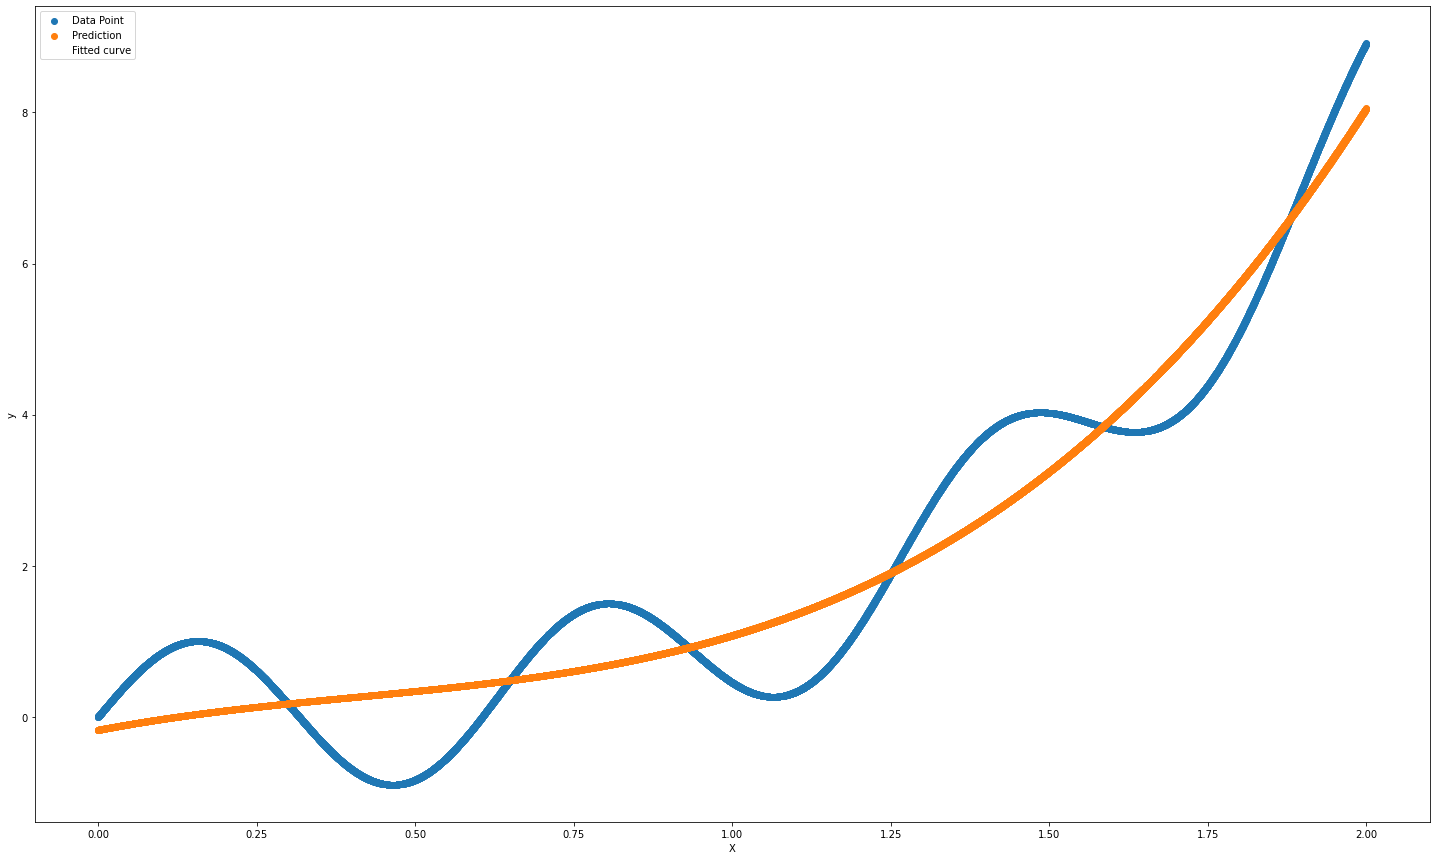

In [12]:
custom_model = Mini_Batch_GD()
history = custom_model.fit(X, y, 1000,0.001, batch=50)

_, y_pred = custom_model.predict(X, y)

plt.figure(figsize=(25, 15))
plt.scatter(X, y, label="Data Point")
plt.scatter(X, y_pred, label="Prediction")
plt.plot(X, y_pred, color="none", label="Fitted curve")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

#### A simple vista, el modelo parece encontrarse haciendo un buen fitting para el dataset propuesto. Para saber si nos encontramos haciendo efectivamente un buen fitting, overfitting o underfitting, tomaremos en cuenta el siguiente criterio:
-Si el modelo funciona claramente mejor con el conjunto de entrenamiento que en el conjunto de prueba, probablemente nos encontremos ante un caso de overfitting.

-Si por el contrario, nuestro modelo funciona mejor con el conjunto de datos de prueba que con el conjunto de datos de entrenamiento, probablemente estemos incurriendo en underfitting.

-Finalmente, si no se presentan ninguno de los 2 casos antes mencionados, el modelo se encuentra haciendo un buen fitting del dataset provisto.

#### Dividiremos nuestro dataset en Train y Validation, y cotejaremos los resultados que arroje la función de costo para el modelo entrenado, y luego para el conjunto de validación:

#### Split en Train y Validation

In [24]:
n = X.shape[0]
print(n)
idx = np.random.permutation(np.arange(0, n))
train_idx = idx[0:int(0.70 * n)]
valid_idx = idx[int(0.70 * n):int(0.90 * n)]
test_idx = idx[int(0.90 * n):]
print(len(train_idx))
print(len(valid_idx))
print(len(test_idx))

10000
7000
2000
1000


In [25]:
X_train = X[train_idx]
y_train = y[train_idx]
X_valid = X[valid_idx]
y_valid = y[valid_idx]
X_test = X[test_idx]
y_test = y[test_idx]

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(7000,)
(7000,)
(2000,)
(2000,)
(1000,)
(1000,)


Epoch 0: 0.5786
Epoch 100: 0.5334
Epoch 200: 0.5095
Epoch 300: 0.4932
Epoch 400: 0.4820
Epoch 500: 0.4742
Epoch 600: 0.4686
Epoch 700: 0.4646
Epoch 800: 0.4617
Epoch 900: 0.4595


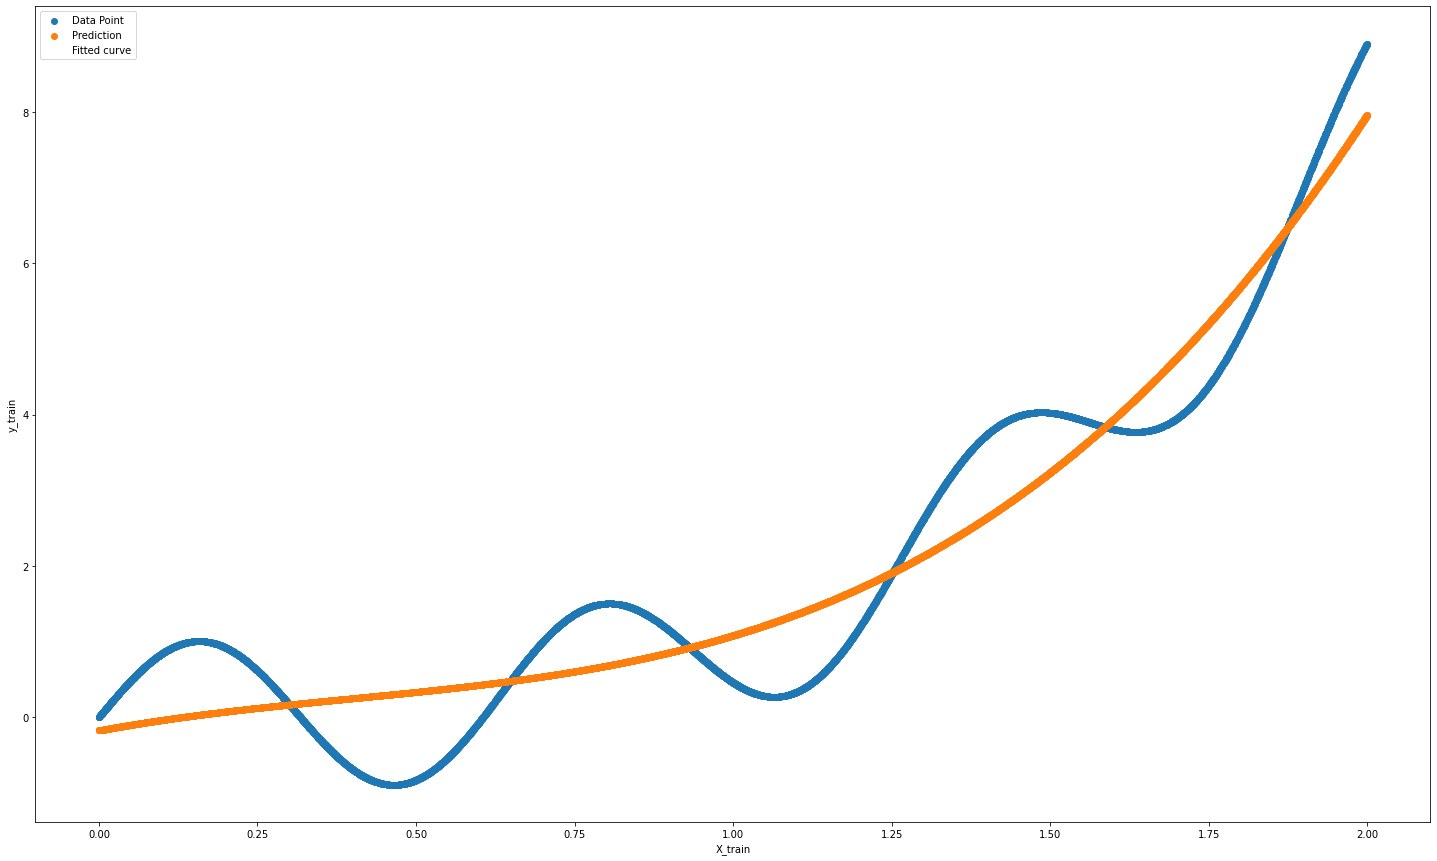

El costo haciendo un 'predict' con el set de train es: 0.5148543844398258


In [26]:
final_model = Mini_Batch_GD()
history = final_model.fit(X_train, y_train, 1000,0.001, batch=50)

cost_train, y_pred_train = final_model.predict(X_train, y_train)

plt.figure(figsize=(25, 15))
plt.scatter(X_train, y_train, label="Data Point")
plt.scatter(X_train, y_pred_train, label="Prediction")
plt.plot(X_train, y_pred_train, color="none", label="Fitted curve")
plt.xlabel("X_train")
plt.ylabel("y_train")
plt.legend()
plt.show()

print ("El costo haciendo un 'predict' con el set de train es:", cost_train.mean())

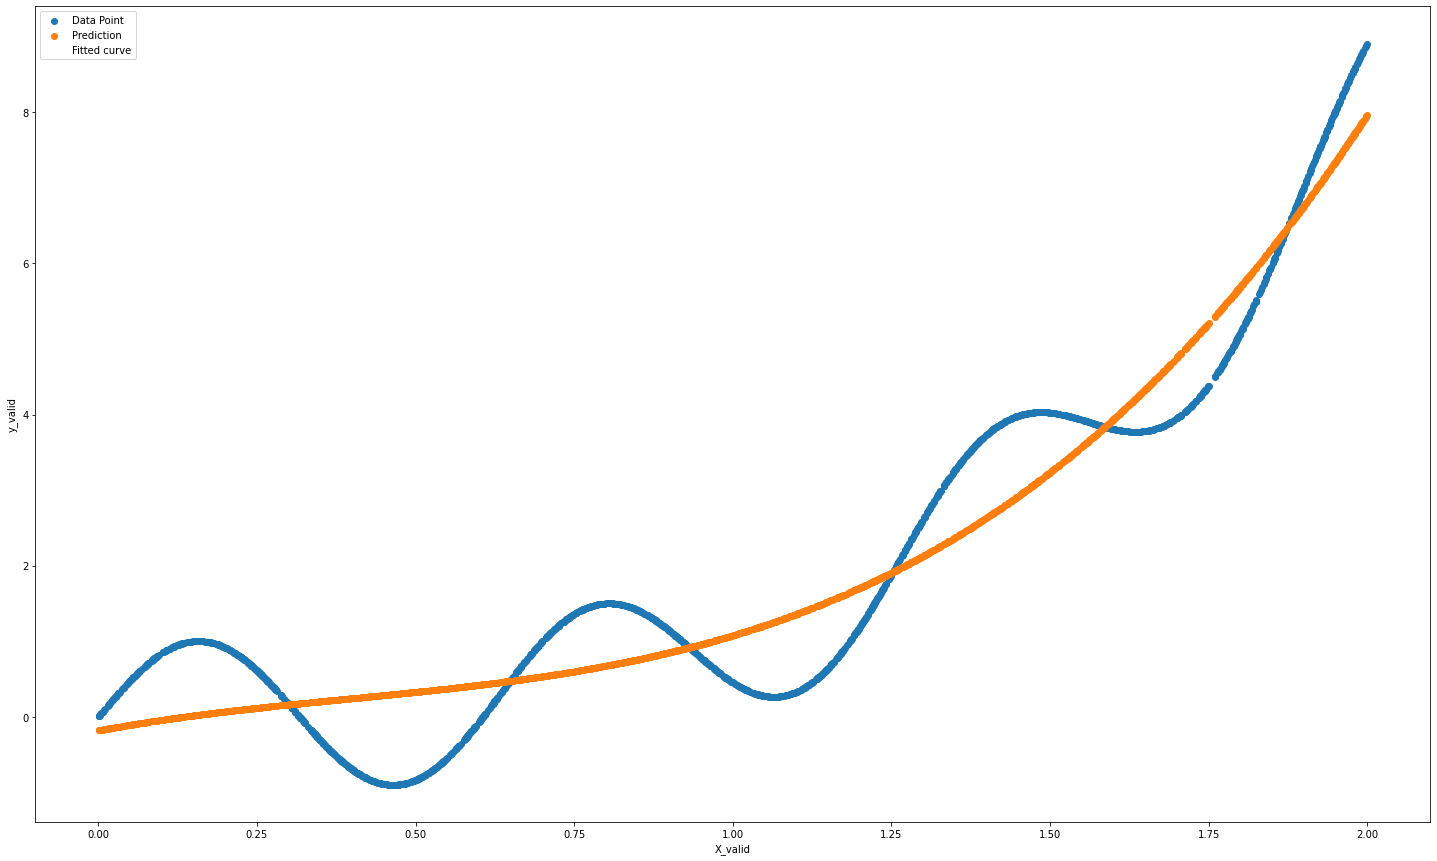

El costo haciendo un 'predict' con el set de validación es: 0.508845343637605


In [28]:
cost_validation, y_pred_valid = final_model.predict(X_valid, y_valid)

plt.figure(figsize=(25, 15))
plt.scatter(X_valid, y_valid, label="Data Point")
plt.scatter(X_valid, y_pred_valid, label="Prediction")
plt.plot(X_valid, y_pred_valid, color="none", label="Fitted curve")
plt.xlabel("X_valid")
plt.ylabel("y_valid")
plt.legend()
plt.show()
print("El costo haciendo un 'predict' con el set de validación es:",cost_validation.mean())

#### Por lo que vemos, los resultados arrojados gráficamente son muy similares, mientras que los valores de la función de costo para cada set de datos, no son muy distintos (hay una diferencia menor al 1% entre el costo del modelo entrenado con el set de Train, respecto al obtenido (con el modelo entrenado) con el set de validación) por lo que nos encontramos ante un modelo que se encuentra haciendo un buen fitting del dataset proveído.

### 2)

In [92]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [157]:
dataset = {
    'train': MyDataset(X_train, y_train),
    'valid': MyDataset(X_valid, y_valid),
    'test':  MyDataset(X_test, y_test)
}

dataloader = {
    'train_to_predict': DataLoader(dataset['train'], shuffle=False, batch_size=64),
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'valid':   DataLoader(dataset['valid'], shuffle=False, batch_size=64),
    'test':  DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [158]:
batch_train = next(iter(dataloader['train']))
batch_valid = next(iter(dataloader['valid']))
batch_test  = next(iter(dataloader['test']))

In [159]:
class NNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=1, out_features=200, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=200, out_features=150, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=150, out_features=150, bias=True)
        self.relu_3 = torch.nn.ReLU()
        self.linear_4 = torch.nn.Linear(in_features=150, out_features=100, bias=True)
        self.relu_4 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=100, out_features=1, bias=True)

    def forward(self, x): 
        x = self.linear_1(x) 
        x = self.relu_1(x) 
        x = self.linear_2(x) 
        x = self.relu_2(x) 
        x = self.linear_3(x) 
        x = self.relu_3(x)
        x = self.linear_4(x) 
        x = self.relu_4(x) 
        x = self.output(x) 
        return x

In [160]:
nnet = NNet()

In [161]:
x_batch = next(iter(dataloader["train"]))
y_batch = nnet(torch.reshape(x_batch[0].float(), (-1, 1)))
print(x_batch[0].shape)
print(y_batch.shape)

torch.Size([64])
torch.Size([64, 1])


In [162]:
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss(reduction="mean")

In [163]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cpu


In [164]:
nnet.to(device)

NNet(
  (linear_1): Linear(in_features=1, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=150, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=150, out_features=150, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=150, out_features=100, bias=True)
  (relu_4): ReLU()
  (output): Linear(in_features=100, out_features=1, bias=True)
)

In [523]:
def fit(model, criterion, train_loader, validation_loader, optimizer, epochs=200):
    
    loss_list_train = []
    loss_list_validation = []
    for epoch in range(epochs):
        total_train=0
        total_validation=0
        for i, data_set in enumerate(train_loader):

            # datos del batch
            X_batch_data, y_batch_data = data_set 
            X_batch_data = X_batch_data.to(device).float()
            Y_batch_data = y_batch_data.to(device).float()
            Y_batch_data = torch.reshape(Y_batch_data , (-1,1))

            # forward
            optimizer.zero_grad()
            y_batch_score_data = model(torch.reshape(X_batch_data , (-1,1)))

            # backpropagation
            loss_data = criterion(y_batch_score_data, Y_batch_data) 
            loss_data.backward() # hacer los gradientes del loss

            # actualización de parametros
            optimizer.step() 
            # completo la lista de los losses por epochs
            
            total_train+=loss_data.item()
        loss_list_train.append(total_train)
        
        
        for i, data_set_val in enumerate(validation_loader):

            # datos del batch
            X_batch, y_batch = data_set_val 
            X_batch = X_batch.to(device).float()
            Y_batch = y_batch.to(device).float()
            Y_batch = torch.reshape(Y_batch , (-1,1))

            # forward
            y_batch_score = model(torch.reshape(X_batch , (-1,1)))

            loss = criterion(y_batch_score, Y_batch) 
            # completo la lista de los losses por epochs
            
            total_validation+=loss.item()
        
        # metrics
        loss_list_validation.append(total_validation)
   
        print(f"Epoch {epoch} | Training loss: {loss_list_train[epoch]} | Validation loss: {loss_list_validation[epoch]}")

    figure, axis = plt.subplots(1,1, figsize=(14,10))
    x = range(0, len(loss_list_train))
    #plt.ylim([0,10])
    plt.plot(x, loss_list_train, 'r--')
    plt.plot(x, loss_list_validation, 'b-')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Losses')
    plt.show();

    return loss_list_train[epoch], loss_list_validation[epoch]

Epoch 0 | Training loss: 175.25449550151825 | Validation loss: 13.984085828065872
Epoch 1 | Training loss: 36.740106627345085 | Validation loss: 9.41841772198677
Epoch 2 | Training loss: 26.58178087323904 | Validation loss: 7.390486553311348
Epoch 3 | Training loss: 25.066876158118248 | Validation loss: 7.269243933260441
Epoch 4 | Training loss: 22.761580631136894 | Validation loss: 6.5639660730957985
Epoch 5 | Training loss: 18.95784954354167 | Validation loss: 5.914279244840145
Epoch 6 | Training loss: 16.929264534264803 | Validation loss: 4.696189187467098
Epoch 7 | Training loss: 9.25046999193728 | Validation loss: 1.4066933151334524
Epoch 8 | Training loss: 2.9878173016477376 | Validation loss: 0.450013202149421
Epoch 9 | Training loss: 0.42240944039076567 | Validation loss: 0.22957362397573888
Epoch 10 | Training loss: 0.17552187707042322 | Validation loss: 0.025248541758628562
Epoch 11 | Training loss: 0.13034642906859517 | Validation loss: 0.044533042644616216
Epoch 12 | Traini

Epoch 97 | Training loss: 0.11494561891595367 | Validation loss: 0.03678909904556349
Epoch 98 | Training loss: 0.06933371869672555 | Validation loss: 0.03618957143044099
Epoch 99 | Training loss: 0.3358544688380789 | Validation loss: 0.3409946928732097
Epoch 100 | Training loss: 0.09666215697507141 | Validation loss: 0.013241906155599281
Epoch 101 | Training loss: 0.07761280958948191 | Validation loss: 0.026833734067622572
Epoch 102 | Training loss: 0.5284357697382802 | Validation loss: 0.017864253561128862
Epoch 103 | Training loss: 0.040143811755115166 | Validation loss: 0.010744066632469185
Epoch 104 | Training loss: 0.1118223891389789 | Validation loss: 0.03319683269364759
Epoch 105 | Training loss: 0.7638777963002212 | Validation loss: 0.047193358768709004
Epoch 106 | Training loss: 0.08767915466160048 | Validation loss: 0.023940758837852627
Epoch 107 | Training loss: 0.0975923175283242 | Validation loss: 0.021670188172720373
Epoch 108 | Training loss: 0.2158634650404565 | Validat

Epoch 192 | Training loss: 0.035555727143218974 | Validation loss: 0.004679143225075677
Epoch 193 | Training loss: 0.010966750576699269 | Validation loss: 0.007035088347038254
Epoch 194 | Training loss: 1.0253585964346712 | Validation loss: 0.143977380823344
Epoch 195 | Training loss: 0.04951125437946757 | Validation loss: 0.0030199841712601483
Epoch 196 | Training loss: 0.008250372929978766 | Validation loss: 0.001374986956761859
Epoch 197 | Training loss: 0.007110051365998515 | Validation loss: 0.0017264819925912889
Epoch 198 | Training loss: 0.007789244504238013 | Validation loss: 0.004603561683325097
Epoch 199 | Training loss: 0.01263155355809431 | Validation loss: 0.001753371543600224
Epoch 200 | Training loss: 0.006558724330716359 | Validation loss: 0.0021595489160972647
Epoch 201 | Training loss: 0.008856862552420353 | Validation loss: 0.0017562069733685348
Epoch 202 | Training loss: 0.048730370372140897 | Validation loss: 0.020099364628549665
Epoch 203 | Training loss: 0.025973

Epoch 286 | Training loss: 0.009911162329444778 | Validation loss: 0.0005934477221671841
Epoch 287 | Training loss: 0.0035244678947492503 | Validation loss: 0.007656041285372339
Epoch 288 | Training loss: 0.0100299964142323 | Validation loss: 0.003514147858368233
Epoch 289 | Training loss: 0.029479761889888323 | Validation loss: 0.04534436704125255
Epoch 290 | Training loss: 0.05494578515390458 | Validation loss: 0.003257536307501141
Epoch 291 | Training loss: 0.0069181272492642165 | Validation loss: 0.003398004329937976
Epoch 292 | Training loss: 0.007739525726719876 | Validation loss: 0.0019486612000036985
Epoch 293 | Training loss: 0.007275733745700563 | Validation loss: 0.002263949209009297
Epoch 294 | Training loss: 0.0234075528314861 | Validation loss: 0.01608187274541706
Epoch 295 | Training loss: 0.04438744388789928 | Validation loss: 0.06938407861161977
Epoch 296 | Training loss: 0.11566635477356613 | Validation loss: 0.01812655254616402
Epoch 297 | Training loss: 0.0166894996

Epoch 380 | Training loss: 0.02859775734532377 | Validation loss: 0.0013190806512284325
Epoch 381 | Training loss: 0.0035584145025495673 | Validation loss: 0.004250228274031542
Epoch 382 | Training loss: 0.03013086366809148 | Validation loss: 0.020033421751577407
Epoch 383 | Training loss: 0.03361347432837647 | Validation loss: 0.0029138698810129426
Epoch 384 | Training loss: 0.006997112191129418 | Validation loss: 0.0010545640070631634
Epoch 385 | Training loss: 0.009334821472293697 | Validation loss: 0.0035635036692838185
Epoch 386 | Training loss: 0.5728114909306896 | Validation loss: 0.37863598857074976
Epoch 387 | Training loss: 0.7143663558163098 | Validation loss: 0.002862304823793238
Epoch 388 | Training loss: 0.005823067869641818 | Validation loss: 0.0011906918416570988
Epoch 389 | Training loss: 0.002333213843030535 | Validation loss: 0.0004937143603456207
Epoch 390 | Training loss: 0.0020235378792676784 | Validation loss: 0.00046196394941944163
Epoch 391 | Training loss: 0.0

Epoch 473 | Training loss: 0.02470892361816368 | Validation loss: 0.015525525173870847
Epoch 474 | Training loss: 0.02507587525724375 | Validation loss: 0.0017465646815253422
Epoch 475 | Training loss: 0.007531900562753435 | Validation loss: 0.008131538976158481
Epoch 476 | Training loss: 0.09444701043139503 | Validation loss: 0.001417821320501389
Epoch 477 | Training loss: 0.004702207896116306 | Validation loss: 0.0024072141022770666
Epoch 478 | Training loss: 0.006751341467861494 | Validation loss: 0.0015183186187641695
Epoch 479 | Training loss: 0.004720150902358 | Validation loss: 0.0020544449253065977
Epoch 480 | Training loss: 0.10480618135170516 | Validation loss: 0.03359345596982166
Epoch 481 | Training loss: 0.04866136605687643 | Validation loss: 0.00045042521651339484
Epoch 482 | Training loss: 0.0016591942708146235 | Validation loss: 0.0016355366624338785
Epoch 483 | Training loss: 0.15269212160364987 | Validation loss: 0.07599008444231004
Epoch 484 | Training loss: 0.025589

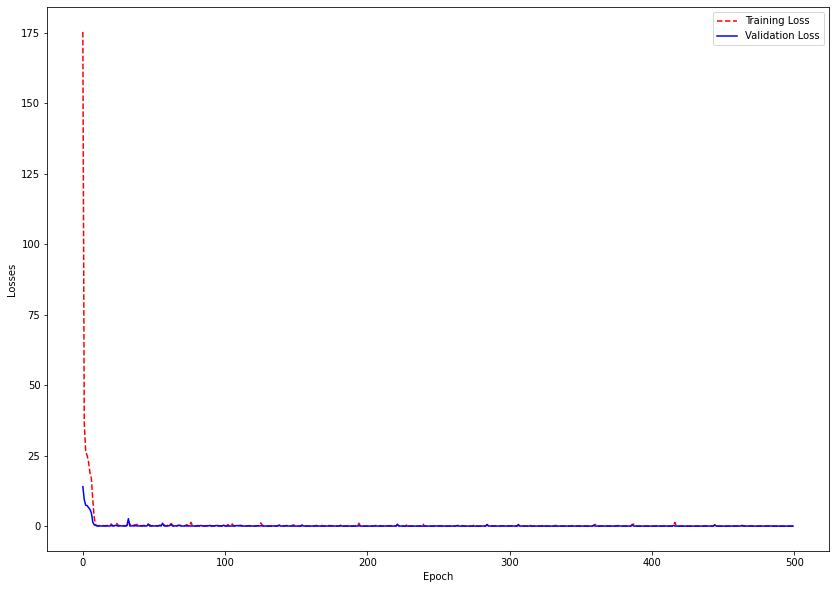

(0.0071472399513368146, 0.0010534483844821807)

In [173]:
fit(nnet, loss_function, dataloader["train"], dataloader["valid"], optimizer, epochs=500)

Epoch 0 | Training loss: 0.11893214794054074 | Validation loss: 0.05985738104209304
Epoch 1 | Training loss: 0.20268147445676732 | Validation loss: 0.003888054401613772
Epoch 2 | Training loss: 0.014579900330318196 | Validation loss: 0.007404334610328078
Epoch 3 | Training loss: 0.012507750022450637 | Validation loss: 0.0016020455041143578
Epoch 4 | Training loss: 0.003821066146429075 | Validation loss: 0.0018843998077500146
Epoch 5 | Training loss: 0.009134556776643876 | Validation loss: 0.0005229160424278234
Epoch 6 | Training loss: 0.00280830969222734 | Validation loss: 0.0005728415790144936
Epoch 7 | Training loss: 0.004222204106554273 | Validation loss: 0.007471678574802354
Epoch 8 | Training loss: 0.0754138609408983 | Validation loss: 0.0288187395199202
Epoch 9 | Training loss: 0.06853940667224379 | Validation loss: 0.001284789197598002
Epoch 10 | Training loss: 0.001995528617499076 | Validation loss: 0.0005001685012757662
Epoch 11 | Training loss: 0.0027619102665994433 | Validat

Epoch 94 | Training loss: 0.001285581197407737 | Validation loss: 0.0002472558294357441
Epoch 95 | Training loss: 0.005372840240852383 | Validation loss: 0.0021799931273562834
Epoch 96 | Training loss: 0.018347666567024135 | Validation loss: 0.0017998679213633295
Epoch 97 | Training loss: 0.02725532400791053 | Validation loss: 0.002229893460025778
Epoch 98 | Training loss: 0.0028254338940314483 | Validation loss: 0.0008866183616191847
Epoch 99 | Training loss: 0.0017524989843877847 | Validation loss: 0.0004186900637250801
Epoch 100 | Training loss: 0.004376702108402242 | Validation loss: 0.00042189126816083444
Epoch 101 | Training loss: 0.04971072951138922 | Validation loss: 0.01957674155710265
Epoch 102 | Training loss: 0.04458005951164523 | Validation loss: 0.005946503399172798
Epoch 103 | Training loss: 0.013473204503497982 | Validation loss: 0.0007614169662701897
Epoch 104 | Training loss: 0.006840856364760839 | Validation loss: 0.0014126390724413795
Epoch 105 | Training loss: 0.21

Epoch 187 | Training loss: 0.0008439701744009653 | Validation loss: 0.00017344365573990217
Epoch 188 | Training loss: 0.0016895351168386696 | Validation loss: 0.0017716194779495709
Epoch 189 | Training loss: 0.0009501765080131008 | Validation loss: 0.0004910281068077893
Epoch 190 | Training loss: 0.001012903751416161 | Validation loss: 0.00033094450873250025
Epoch 191 | Training loss: 0.03759042812271218 | Validation loss: 0.02729201948386617
Epoch 192 | Training loss: 0.04348612547619268 | Validation loss: 0.00669021085195709
Epoch 193 | Training loss: 0.0033862684458654257 | Validation loss: 0.0008049377229326637
Epoch 194 | Training loss: 0.007478758016532083 | Validation loss: 0.0008460473909508437
Epoch 195 | Training loss: 0.00471900059028485 | Validation loss: 0.0015647114123567007
Epoch 196 | Training loss: 0.003546450207068119 | Validation loss: 0.0007520894487242913
Epoch 197 | Training loss: 0.017947752097825287 | Validation loss: 0.007252828610944562
Epoch 198 | Training lo

Epoch 280 | Training loss: 0.001857770462947883 | Validation loss: 0.00043143123821209883
Epoch 281 | Training loss: 0.012239501484827997 | Validation loss: 0.022010036162100732
Epoch 282 | Training loss: 0.04623596405508579 | Validation loss: 0.0008744188126001973
Epoch 283 | Training loss: 0.0034865579825691384 | Validation loss: 0.002450292191497283
Epoch 284 | Training loss: 0.003226366961371241 | Validation loss: 0.001061449713233742
Epoch 285 | Training loss: 0.02924838868329971 | Validation loss: 0.0015822486893739551
Epoch 286 | Training loss: 0.007578345204819925 | Validation loss: 0.013242590997833759
Epoch 287 | Training loss: 0.5757745323717245 | Validation loss: 0.053507335076574236
Epoch 288 | Training loss: 0.13344845620486012 | Validation loss: 0.0011175342897331575
Epoch 289 | Training loss: 0.0017907597307385004 | Validation loss: 0.00043723639919335255
Epoch 290 | Training loss: 0.0011619172105383768 | Validation loss: 0.00028038510390615556
Epoch 291 | Training loss

Epoch 373 | Training loss: 0.004455298856555601 | Validation loss: 0.00139156952900521
Epoch 374 | Training loss: 0.00600498721587428 | Validation loss: 0.0017290684863837669
Epoch 375 | Training loss: 0.0064061307202791795 | Validation loss: 0.0013323333514563274
Epoch 376 | Training loss: 0.004671172885082342 | Validation loss: 0.004497574678680394
Epoch 377 | Training loss: 0.03093988912041823 | Validation loss: 0.006658533922745846
Epoch 378 | Training loss: 0.19777453083224827 | Validation loss: 0.013161648690584116
Epoch 379 | Training loss: 0.007996174308573245 | Validation loss: 0.0010584434457996394
Epoch 380 | Training loss: 0.0020952972990926355 | Validation loss: 0.00033756773791537853
Epoch 381 | Training loss: 0.003085453679886996 | Validation loss: 0.0006126810167188523
Epoch 382 | Training loss: 0.002586167516255955 | Validation loss: 0.0011535803596416372
Epoch 383 | Training loss: 0.0012920872161430452 | Validation loss: 0.0009427468357898761
Epoch 384 | Training loss

Epoch 465 | Training loss: 0.0007436529865572084 | Validation loss: 8.528274975105887e-05
Epoch 466 | Training loss: 0.003784604111842782 | Validation loss: 0.0023957235207490157
Epoch 467 | Training loss: 0.0016675327997290879 | Validation loss: 0.00023783285587342107
Epoch 468 | Training loss: 0.0011948974579354399 | Validation loss: 0.0001396954055508104
Epoch 469 | Training loss: 0.001696510822057462 | Validation loss: 0.0006234578358998988
Epoch 470 | Training loss: 0.12459639563940073 | Validation loss: 0.003179191320668906
Epoch 471 | Training loss: 0.0033418205994166783 | Validation loss: 0.000372554244222556
Epoch 472 | Training loss: 0.0010391826938302984 | Validation loss: 0.0011537347600096837
Epoch 473 | Training loss: 0.0015743081094115041 | Validation loss: 0.0009032825928443344
Epoch 474 | Training loss: 0.001422917907802912 | Validation loss: 0.0009296413263655268
Epoch 475 | Training loss: 0.01003820547794021 | Validation loss: 0.0019249418401159346
Epoch 476 | Traini

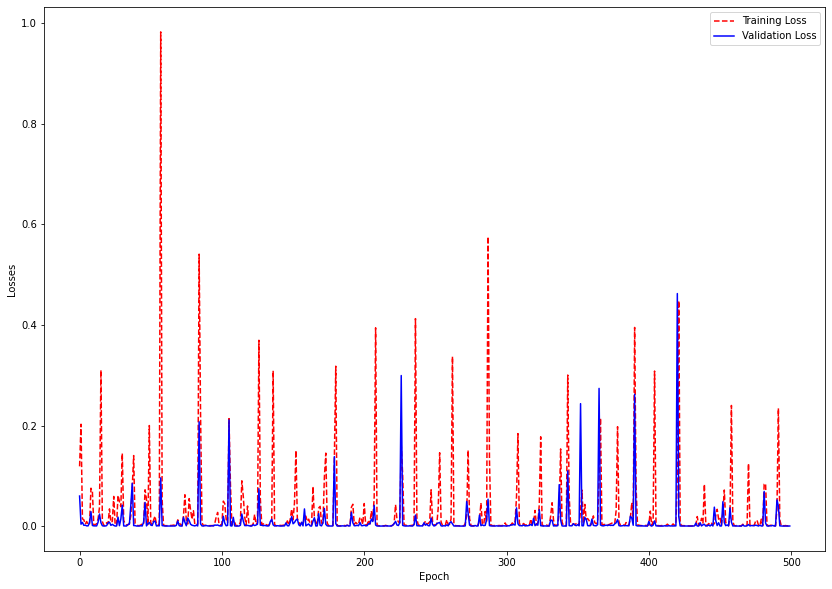

(0.0009431769058210193, 0.0002782191909318499)

In [174]:
fit(nnet, loss_function, dataloader["train"], dataloader["valid"], optimizer, epochs=500)

Se intentó overfittear el modelo a través de un diseño de varias capas y perceptrones en cada una, así como se entrenó 2 veces con 500 epochs la red, para buscar que la loss function en función de las epochs del set de datos de validation, supere al de training luego de varias epochs.
No se llegó a tal resultado (en algunos puntos la loss de la validation supera a la de train, pero la curva no se superpone totalmente), quizás por tratarse de un set de datos no tan complejo como para poder lograr un rápido overfitting con la red neuronal así diseñada.

In [175]:
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = torch.reshape(batch[0].float(), (-1, 1))
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [176]:
y_pred_train = predict(nnet, dataloader['train_to_predict'])
y_pred_valid = predict(nnet, dataloader['valid'])
y_pred_test = predict(nnet, dataloader['test'])

In [177]:
y_pred_train_=[]
for i in range(0,len(y_pred_train)):
    y_pred_train_.append(y_pred_train[i].numpy())

In [178]:
y_pred_valid_=[]
for i in range(0,len(y_pred_valid)):
    y_pred_valid_.append(y_pred_valid[i].numpy())

In [179]:
y_pred_test_=[]
for i in range(0,len(y_pred_test)):
    y_pred_test_.append(y_pred_test[i].numpy())

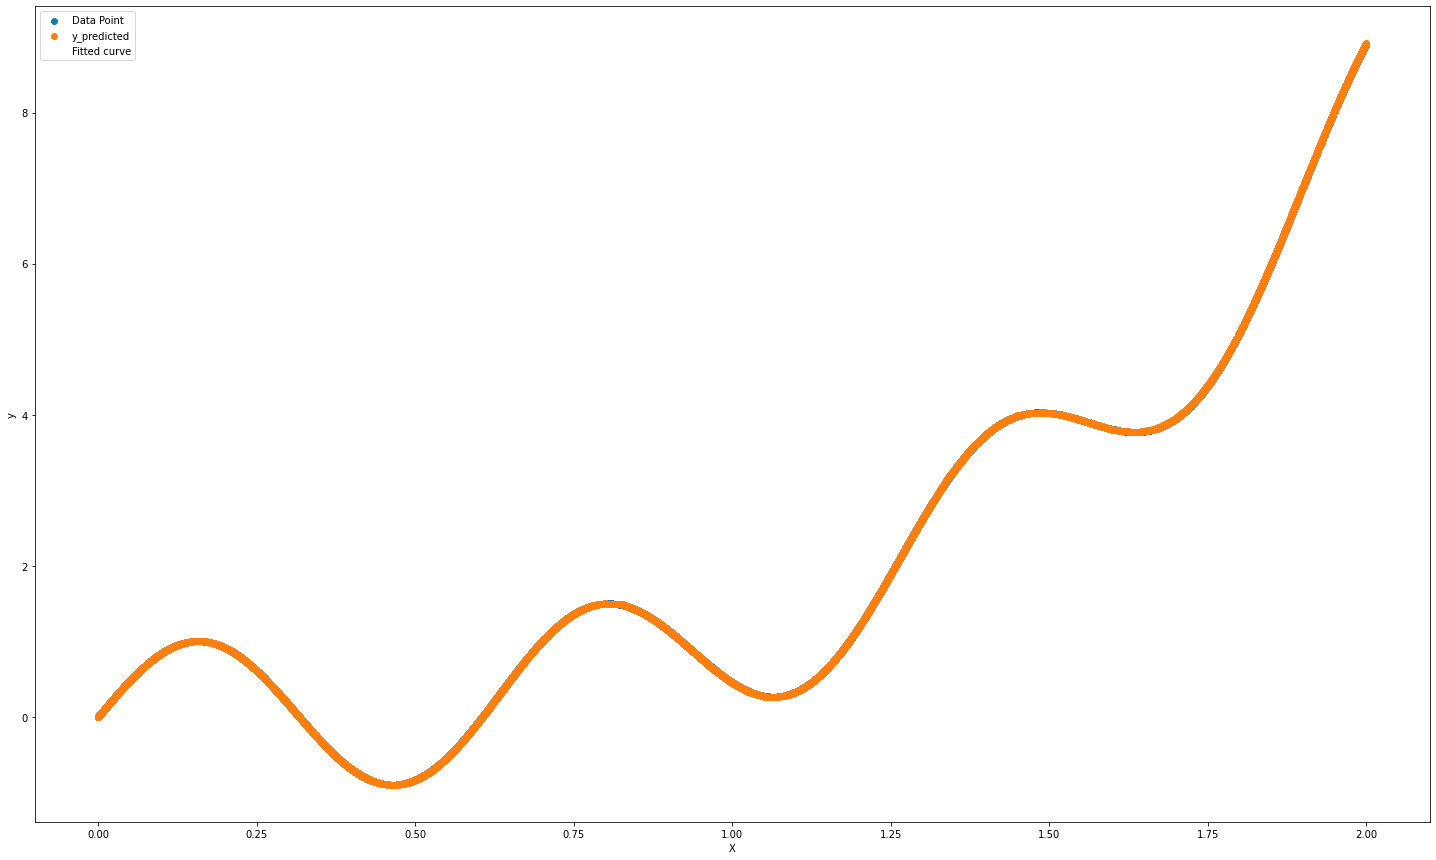

In [182]:
plt.figure(figsize=(25, 15))
plt.scatter(X_train, y_train, label="Data Point")
plt.scatter(X_train, y_pred_train_, label="y_predicted")
plt.plot(X_train, y_pred_train_, color="none", label="Fitted curve")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

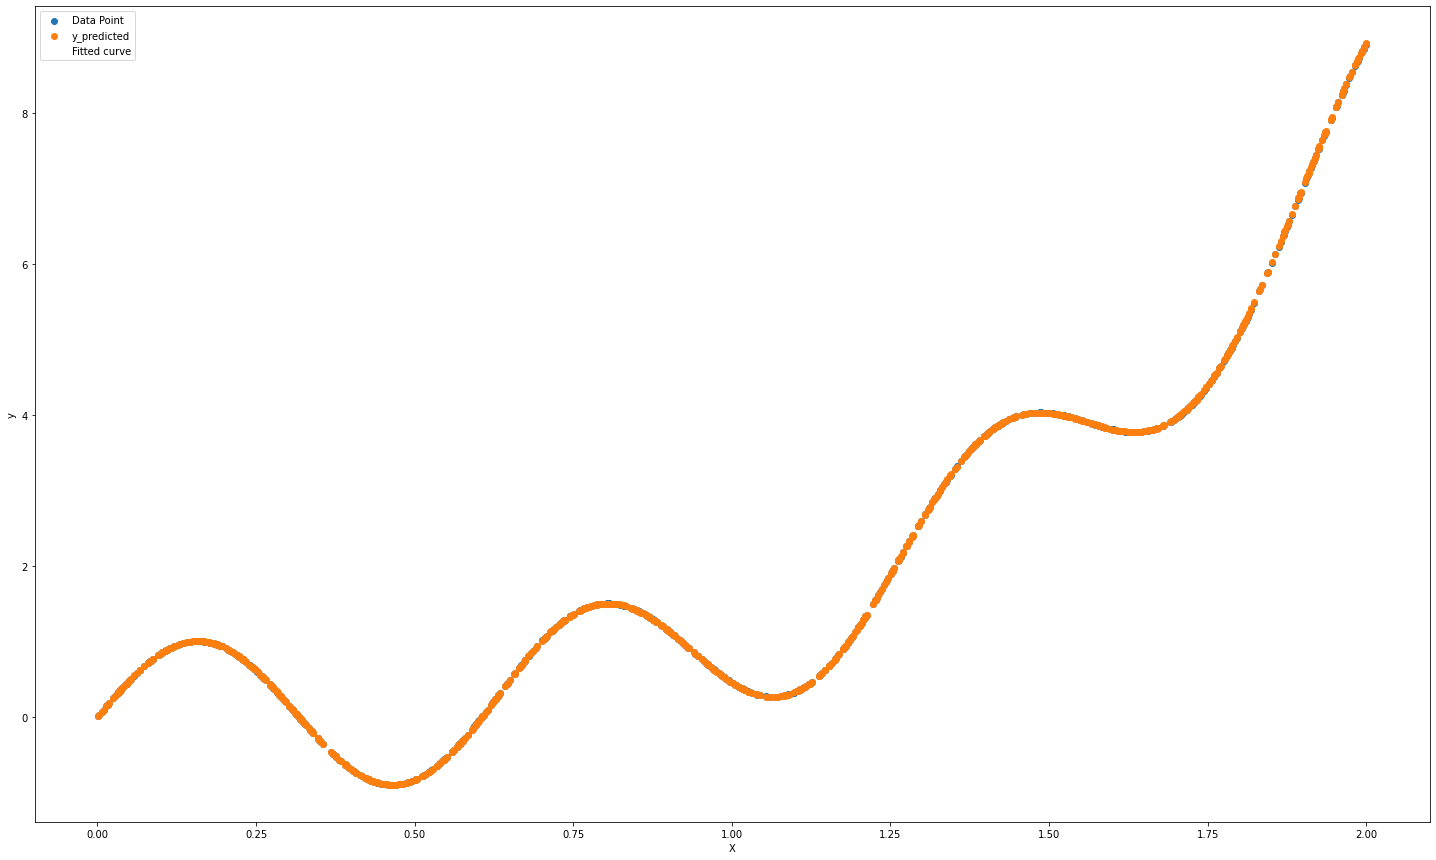

In [185]:
plt.figure(figsize=(25, 15))
plt.scatter(X_test, y_test, label="Data Point")
plt.scatter(X_test, y_pred_test_, label="y_predicted")
plt.plot(X_test, y_pred_test_, color="none", label="Fitted curve")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

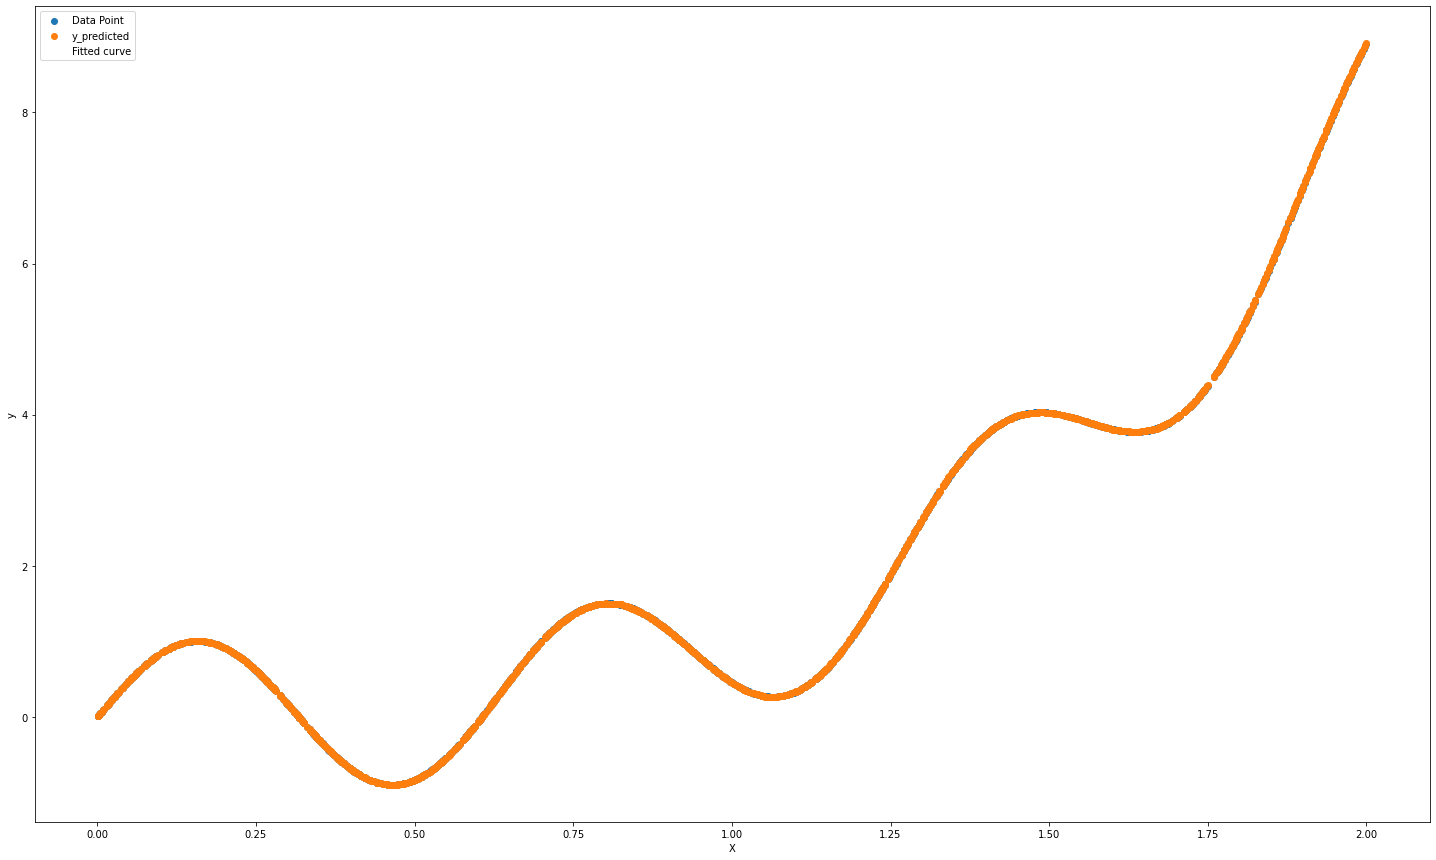

In [186]:
plt.figure(figsize=(25, 15))
plt.scatter(X_valid, y_valid, label="Data Point")
plt.scatter(X_valid, y_pred_valid_, label="y_predicted")
plt.plot(X_valid, y_pred_valid_, color="none", label="Fitted curve")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

Se encontró que el modelo, claramente overfittea para el set de training. No obstante, para los sets de validation y test, la aproximación también es muy buena. 

Se agregará regulación para hacer un fit correcto.

In [273]:
class NNet_with_reg(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=1, out_features=200, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=200, out_features=150, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=150, out_features=150, bias=True)
        self.relu_3 = torch.nn.ReLU()
        self.linear_4 = torch.nn.Linear(in_features=150, out_features=100, bias=True)
        self.relu_4 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=100, out_features=1, bias=True)
        self.dropout = torch.nn.Dropout(0.45)

    def forward(self, x): 
        x = self.linear_1(x) 
        x = self.relu_1(x) 
        x = self.linear_2(x)
        x = self.dropout(x)
        x = self.relu_2(x) 
        x = self.linear_3(x) 
        x = self.dropout(x)
        x = self.relu_3(x)
        x = self.linear_4(x) 
        x = self.dropout(x)
        x = self.relu_4(x)
        x = self.dropout(x)
        x = self.output(x) 
        return x

In [274]:
nnet_dout = NNet_with_reg()

In [275]:
optimizer_dout = torch.optim.Adam(nnet_dout.parameters(), lr=0.001)

Epoch 0 | Training loss: 275.72656071186066 | Validation loss: 47.32862502336502
Epoch 1 | Training loss: 137.0123651623726 | Validation loss: 36.453377306461334
Epoch 2 | Training loss: 121.1499491930008 | Validation loss: 34.163132071495056
Epoch 3 | Training loss: 117.29397851228714 | Validation loss: 35.93087613582611
Epoch 4 | Training loss: 102.8603104352951 | Validation loss: 28.54961633682251
Epoch 5 | Training loss: 99.2784398496151 | Validation loss: 27.377766996622086
Epoch 6 | Training loss: 88.11156433820724 | Validation loss: 27.33594799041748
Epoch 7 | Training loss: 84.46336686611176 | Validation loss: 26.07705208659172
Epoch 8 | Training loss: 85.20471200346947 | Validation loss: 27.99027356505394
Epoch 9 | Training loss: 79.93010756373405 | Validation loss: 22.417001247406006
Epoch 10 | Training loss: 85.57799851894379 | Validation loss: 21.492079854011536
Epoch 11 | Training loss: 84.52363166213036 | Validation loss: 32.688282281160355
Epoch 12 | Training loss: 78.74

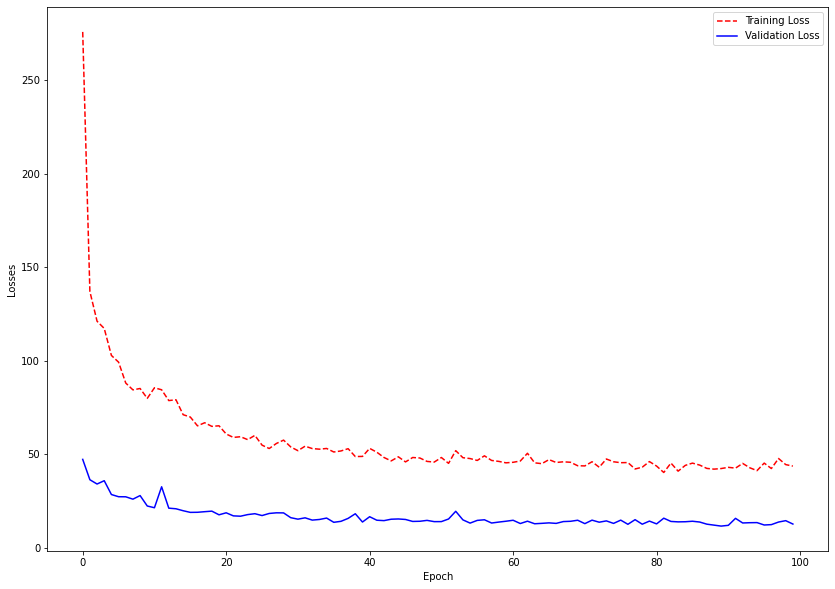

(43.733931466937065, 12.776292368769646)

In [276]:
fit(nnet_dout, loss_function, dataloader["train"], dataloader["valid"], optimizer_dout, epochs=100)

In [277]:
y_pred_train_dout = predict(nnet_dout, dataloader['train_to_predict'])
y_pred_valid_dout = predict(nnet_dout, dataloader['valid'])
y_pred_test_dout = predict(nnet_dout, dataloader['test'])

In [278]:
y_pred_train_dout_=[]
for i in range(0,len(y_pred_train_dout)):
    y_pred_train_dout_.append(y_pred_train_dout[i].numpy())

In [279]:
y_pred_valid_dout_=[]
for i in range(0,len(y_pred_valid_dout)):
    y_pred_valid_dout_.append(y_pred_valid_dout[i].numpy())

In [280]:
y_pred_test_dout_=[]
for i in range(0,len(y_pred_test_dout)):
    y_pred_test_dout_.append(y_pred_test_dout[i].numpy())

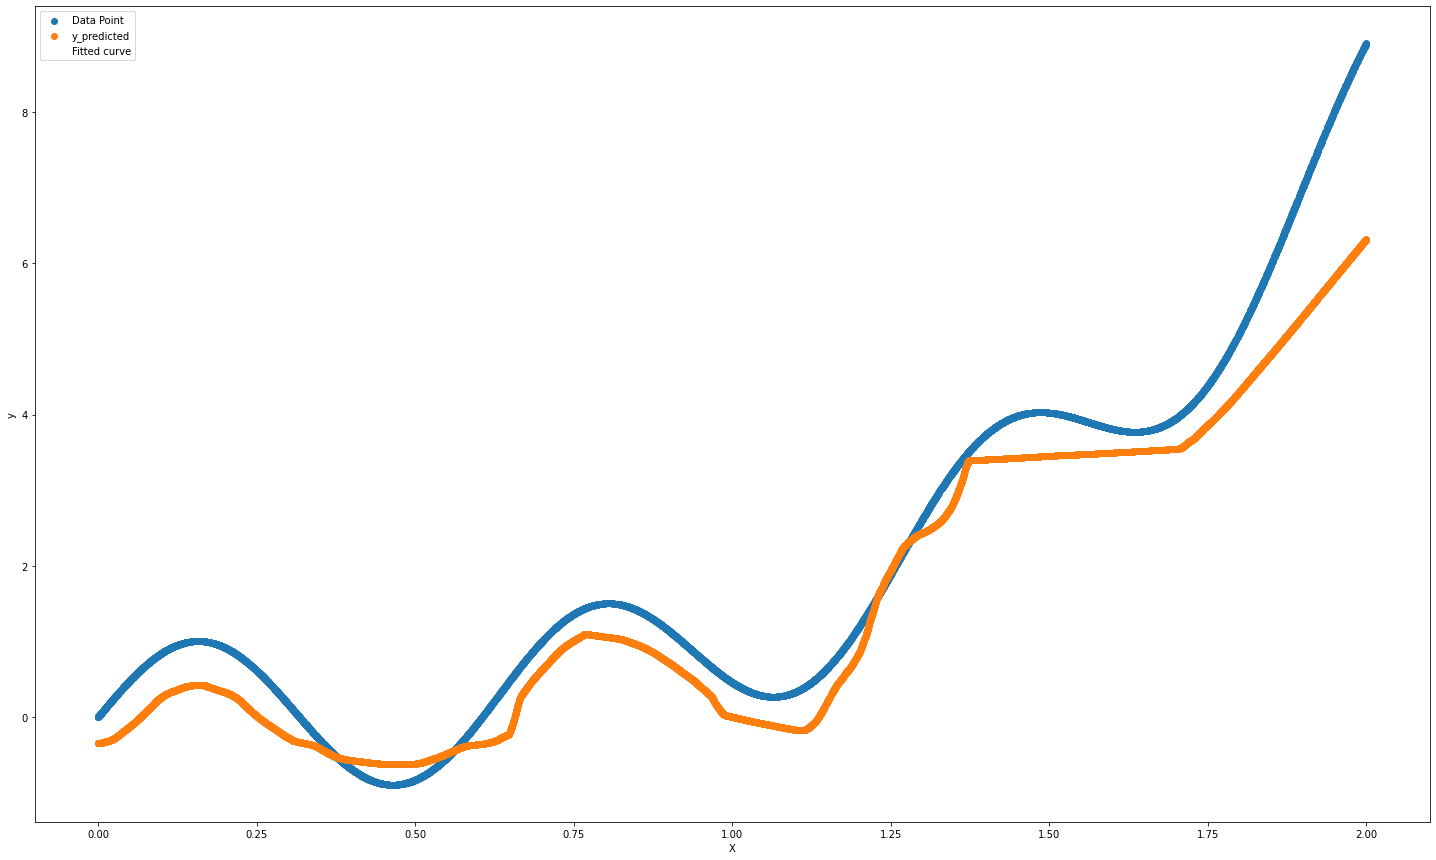

In [281]:
plt.figure(figsize=(25, 15))
plt.scatter(X_train, y_train, label="Data Point")
plt.scatter(X_train, y_pred_train_dout_, label="y_predicted")
plt.plot(X_train, y_pred_train_dout_, color="none", label="Fitted curve")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

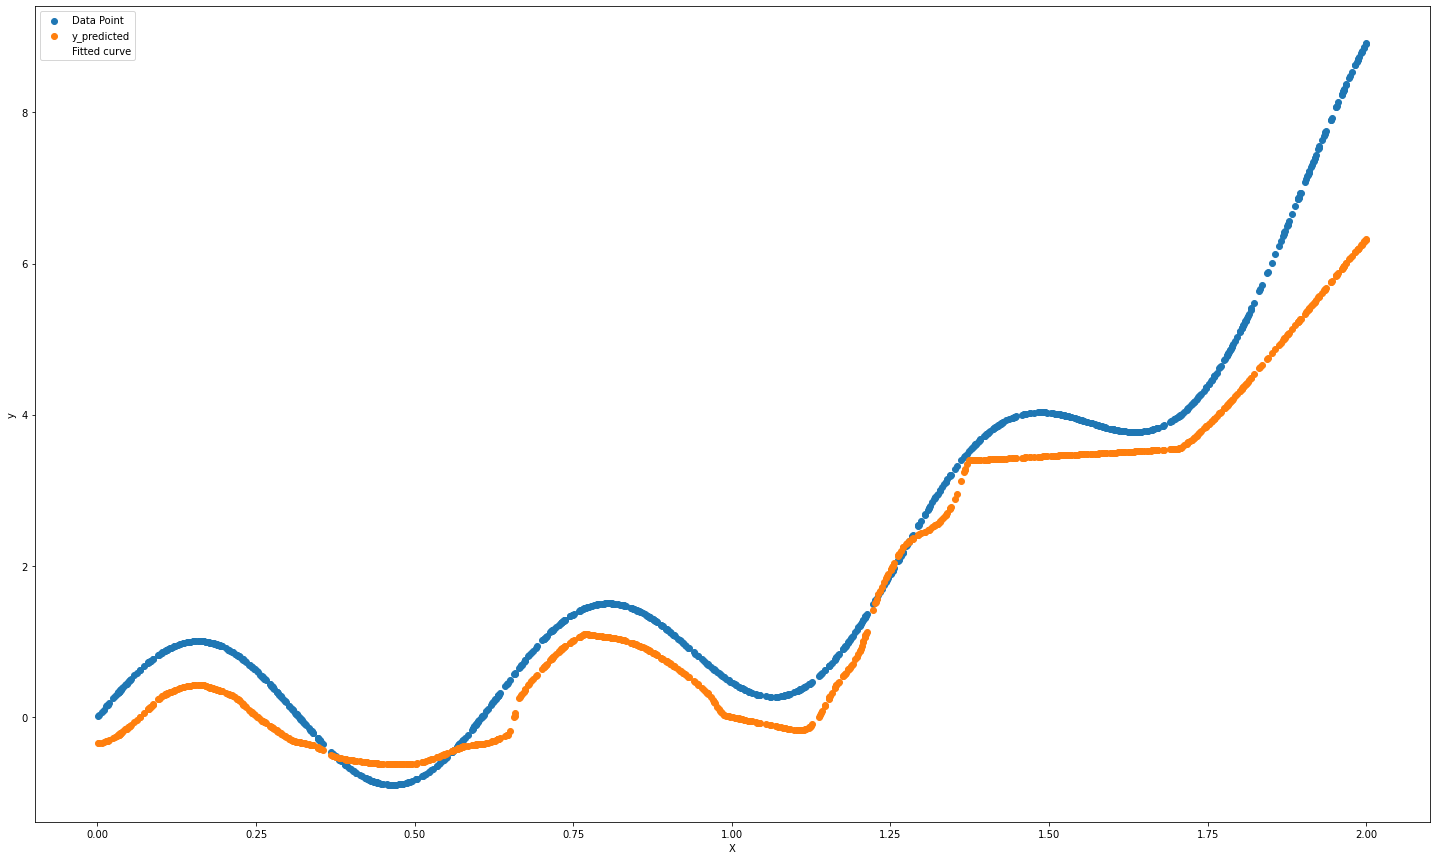

In [282]:
plt.figure(figsize=(25, 15))
plt.scatter(X_test, y_test, label="Data Point")
plt.scatter(X_test, y_pred_test_dout_, label="y_predicted")
plt.plot(X_test, y_pred_test_dout_, color="none", label="Fitted curve")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

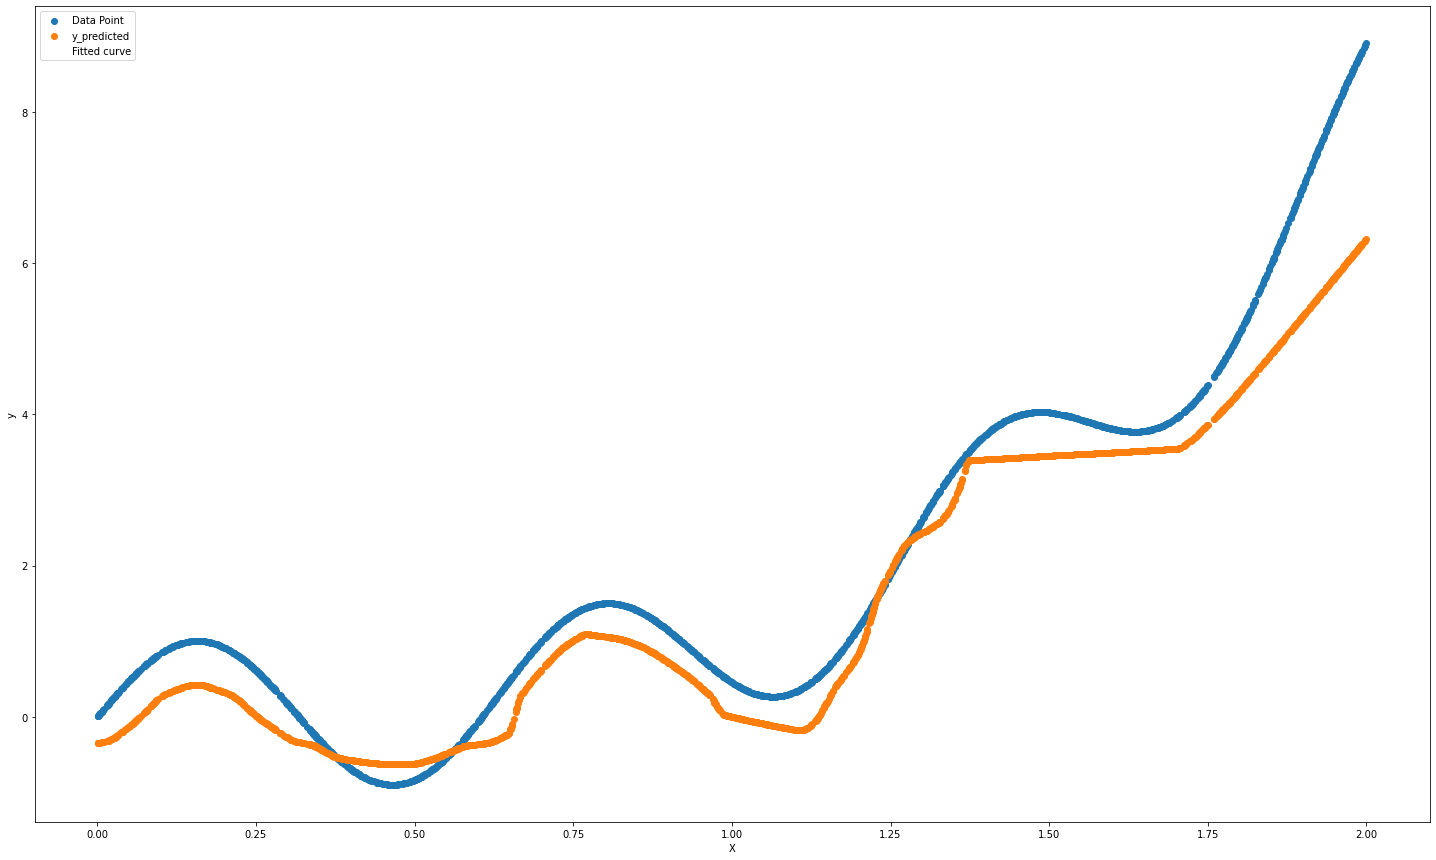

In [285]:
plt.figure(figsize=(25, 15))
plt.scatter(X_valid, y_valid, label="Data Point")
plt.scatter(X_valid, y_pred_valid_dout_, label="y_predicted")
plt.plot(X_valid, y_pred_valid_dout_, color="none", label="Fitted curve")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

Se elimina el overfitting con el utilizando un dropout del 45% en casi todas las capas, entre las capas lineales y las capas de activación (de manera de apagar aleatoriamente algunos perceptrones, que el modelo no refuerce un camino entre capas para el aprendizaje).

### 3)

Análisis exploratorio:

In [4]:
ds = pd.read_csv("dataset_2.csv")

In [5]:
ds.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [6]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [7]:
ds["purchase_label"] = ds.Purchase.apply(lambda label: 0 if label < 9000 else 1)
print(len(ds[ds["purchase_label"] == 0])) # no gastará 'mucha plata' 
print(len(ds[ds["purchase_label"] == 1])) # gastará 'mucha plata'

330871
219197


In [8]:
ds.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
purchase_label                     0
dtype: int64

In [9]:
ds.Gender.value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

In [10]:
ds.Age.value_counts()

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

<AxesSubplot:xlabel='Age,purchase_label'>

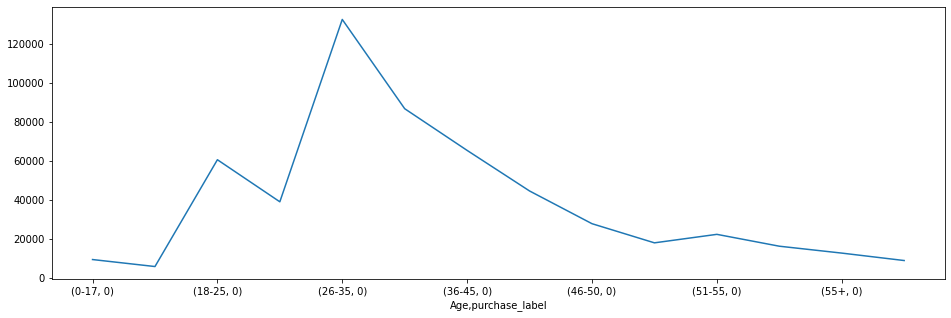

In [11]:
plt.figure(figsize=(16,5))
ds.groupby("Age").purchase_label.value_counts().plot(kind='line')

<AxesSubplot:xlabel='Product_Category_1,purchase_label'>

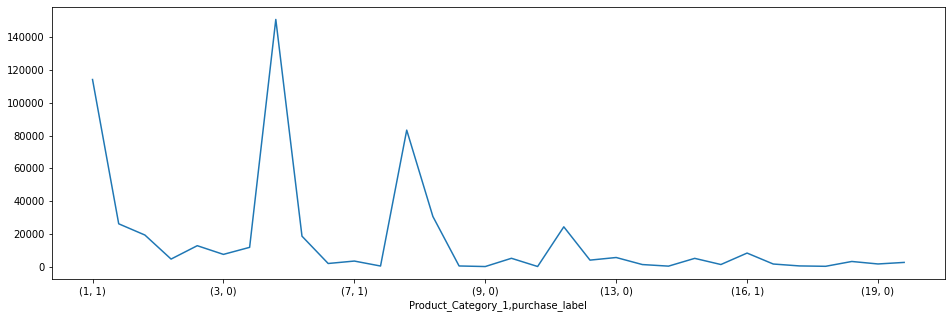

In [12]:
plt.figure(figsize=(16,5))
ds.groupby("Product_Category_1").purchase_label.value_counts().plot(kind='line')

<AxesSubplot:xlabel='Product_Category_2,purchase_label'>

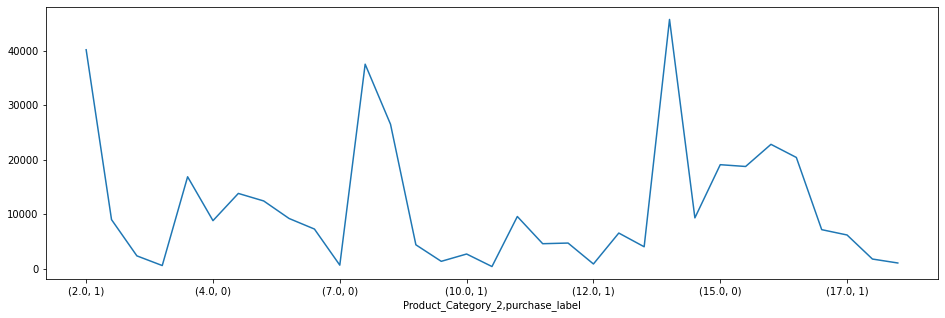

In [13]:
plt.figure(figsize=(16,5))
ds.groupby("Product_Category_2").purchase_label.value_counts().plot(kind='line')

<AxesSubplot:xlabel='Product_Category_3,purchase_label'>

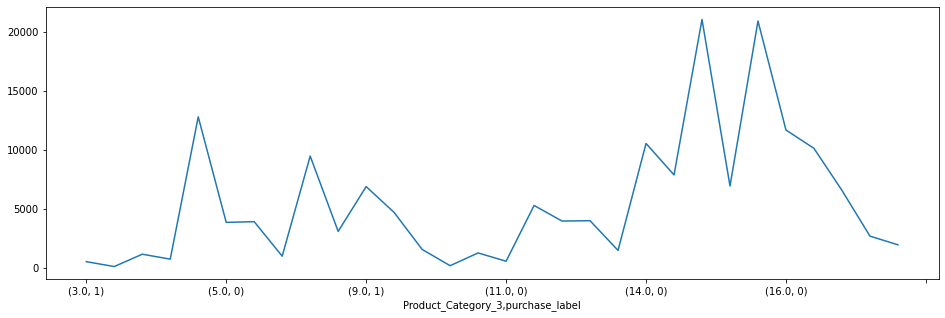

In [14]:
plt.figure(figsize=(16,5))
ds.groupby("Product_Category_3").purchase_label.value_counts().plot(kind='line')

In [15]:
ds.Occupation.value_counts()

4     72308
0     69638
7     59133
1     47426
17    40043
20    33562
12    31179
14    27309
2     26588
16    25371
6     20355
3     17650
10    12930
5     12177
15    12165
11    11586
19     8461
13     7728
18     6622
9      6291
8      1546
Name: Occupation, dtype: int64

In [16]:
ds.City_Category.value_counts()

B    231173
C    171175
A    147720
Name: City_Category, dtype: int64

In [17]:
ds.Stay_In_Current_City_Years.value_counts()

1     193821
2     101838
3      95285
4+     84726
0      74398
Name: Stay_In_Current_City_Years, dtype: int64

In [18]:
ds.Product_Category_1.value_counts()

5     150933
1     140378
8     113925
11     24287
2      23864
6      20466
3      20213
4      11753
16      9828
15      6290
13      5549
10      5125
12      3947
7       3721
18      3125
20      2550
19      1603
14      1523
17       578
9        410
Name: Product_Category_1, dtype: int64

#### Analicemos las variables a efectuar One-Hot Encoding:

Aplicaremos one-hot encoding a las features: Gender, Occupation, City_Category, Stay_In_Current_City_Years y Marital_Status

In [19]:
print(ds["Gender"].unique())
type_dummies = pd.get_dummies(ds["Gender"], prefix="Gender") 
type_dummies.info() 

# Concatena la nueva columna a mi dataset
dataset = pd.concat([ds, type_dummies], axis=1)
dataset.info()

['F' 'M']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   Gender_F  550068 non-null  uint8
 1   Gender_M  550068 non-null  uint8
dtypes: uint8(2)
memory usage: 1.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  

In [20]:
print(ds["Occupation"].unique())
type_dummies = pd.get_dummies(ds["Occupation"], prefix="Occupation") 
type_dummies.info() 

# Concatena la nueva columna a mi dataset
dataset = pd.concat([dataset, type_dummies], axis=1)
dataset.info()

[10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Occupation_0   550068 non-null  uint8
 1   Occupation_1   550068 non-null  uint8
 2   Occupation_2   550068 non-null  uint8
 3   Occupation_3   550068 non-null  uint8
 4   Occupation_4   550068 non-null  uint8
 5   Occupation_5   550068 non-null  uint8
 6   Occupation_6   550068 non-null  uint8
 7   Occupation_7   550068 non-null  uint8
 8   Occupation_8   550068 non-null  uint8
 9   Occupation_9   550068 non-null  uint8
 10  Occupation_10  550068 non-null  uint8
 11  Occupation_11  550068 non-null  uint8
 12  Occupation_12  550068 non-null  uint8
 13  Occupation_13  550068 non-null  uint8
 14  Occupation_14  550068 non-null  uint8
 15  Occupation_15  550068 non-null  uint8
 16  Occupation_16  550068 non-null  uint8
 17  Oc

In [21]:
print(ds["City_Category"].unique())
type_dummies = pd.get_dummies(ds["City_Category"], prefix="City_Category") 
type_dummies.info() 

# Concatena la nueva columna a mi dataset
dataset = pd.concat([dataset, type_dummies], axis=1)
dataset.info()

['A' 'C' 'B']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   City_Category_A  550068 non-null  uint8
 1   City_Category_B  550068 non-null  uint8
 2   City_Category_C  550068 non-null  uint8
dtypes: uint8(3)
memory usage: 1.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  55006

In [22]:
print(ds["Stay_In_Current_City_Years"].unique())
type_dummies = pd.get_dummies(ds["Stay_In_Current_City_Years"], prefix="Stay_In_Current_City_Years") 
type_dummies.info() 

# Concatena la nueva columna a mi dataset
dataset = pd.concat([dataset, type_dummies], axis=1)
dataset.info()

['2' '4+' '3' '1' '0']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype
---  ------                         --------------   -----
 0   Stay_In_Current_City_Years_0   550068 non-null  uint8
 1   Stay_In_Current_City_Years_1   550068 non-null  uint8
 2   Stay_In_Current_City_Years_2   550068 non-null  uint8
 3   Stay_In_Current_City_Years_3   550068 non-null  uint8
 4   Stay_In_Current_City_Years_4+  550068 non-null  uint8
dtypes: uint8(5)
memory usage: 2.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   User_ID                        550068 non-null  int64  
 1   Product_ID                     550068 non-null  object 
 2   Gender                         550068 non-null  object 


In [23]:
print(ds["Marital_Status"].unique())
type_dummies = pd.get_dummies(ds["Marital_Status"], prefix="Marital_Status") 
type_dummies.info() 

# Concatena la nueva columna a mi dataset
dataset = pd.concat([dataset, type_dummies], axis=1)
dataset.info()

[0 1]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Marital_Status_0  550068 non-null  uint8
 1   Marital_Status_1  550068 non-null  uint8
dtypes: uint8(2)
memory usage: 1.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 46 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   User_ID                        550068 non-null  int64  
 1   Product_ID                     550068 non-null  object 
 2   Gender                         550068 non-null  object 
 3   Age                            550068 non-null  object 
 4   Occupation                     550068 non-null  int64  
 5   City_Category                  550068 non-null  object 
 6   Stay_In_Current_City_Years     550068 non-null  object 
 7

#### Limpiamos el dataset:

In [24]:
nans = dataset[ds.isna().sum(axis=1) >= 1]
print(nans.shape)

(383247, 46)


In [25]:
dataset = dataset[ds.isna().sum(axis=1) == 0]
print(dataset.shape)

(166821, 46)


In [26]:
y = dataset["purchase_label"]
X = dataset.drop(["User_ID", "Age", "Product_ID", "Gender", "Occupation", "City_Category", "Stay_In_Current_City_Years", "Marital_Status"], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166821 entries, 1 to 545914
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Product_Category_1             166821 non-null  int64  
 1   Product_Category_2             166821 non-null  float64
 2   Product_Category_3             166821 non-null  float64
 3   Purchase                       166821 non-null  int64  
 4   purchase_label                 166821 non-null  int64  
 5   Gender_F                       166821 non-null  uint8  
 6   Gender_M                       166821 non-null  uint8  
 7   Occupation_0                   166821 non-null  uint8  
 8   Occupation_1                   166821 non-null  uint8  
 9   Occupation_2                   166821 non-null  uint8  
 10  Occupation_3                   166821 non-null  uint8  
 11  Occupation_4                   166821 non-null  uint8  
 12  Occupation_5                  

In [27]:
X.isna().sum()

Product_Category_1               0
Product_Category_2               0
Product_Category_3               0
Purchase                         0
purchase_label                   0
Gender_F                         0
Gender_M                         0
Occupation_0                     0
Occupation_1                     0
Occupation_2                     0
Occupation_3                     0
Occupation_4                     0
Occupation_5                     0
Occupation_6                     0
Occupation_7                     0
Occupation_8                     0
Occupation_9                     0
Occupation_10                    0
Occupation_11                    0
Occupation_12                    0
Occupation_13                    0
Occupation_14                    0
Occupation_15                    0
Occupation_16                    0
Occupation_17                    0
Occupation_18                    0
Occupation_19                    0
Occupation_20                    0
City_Category_A     

In [28]:
X = X.dropna()

In [29]:
X.isna().sum()

Product_Category_1               0
Product_Category_2               0
Product_Category_3               0
Purchase                         0
purchase_label                   0
Gender_F                         0
Gender_M                         0
Occupation_0                     0
Occupation_1                     0
Occupation_2                     0
Occupation_3                     0
Occupation_4                     0
Occupation_5                     0
Occupation_6                     0
Occupation_7                     0
Occupation_8                     0
Occupation_9                     0
Occupation_10                    0
Occupation_11                    0
Occupation_12                    0
Occupation_13                    0
Occupation_14                    0
Occupation_15                    0
Occupation_16                    0
Occupation_17                    0
Occupation_18                    0
Occupation_19                    0
Occupation_20                    0
City_Category_A     

#### Normalizo:

In [30]:
X_norm = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

In [31]:
print(np.min(X_norm, axis=0))
print(np.max(X_norm, axis=0))

Product_Category_1               0.0
Product_Category_2               0.0
Product_Category_3               0.0
Purchase                         0.0
purchase_label                   0.0
Gender_F                         0.0
Gender_M                         0.0
Occupation_0                     0.0
Occupation_1                     0.0
Occupation_2                     0.0
Occupation_3                     0.0
Occupation_4                     0.0
Occupation_5                     0.0
Occupation_6                     0.0
Occupation_7                     0.0
Occupation_8                     0.0
Occupation_9                     0.0
Occupation_10                    0.0
Occupation_11                    0.0
Occupation_12                    0.0
Occupation_13                    0.0
Occupation_14                    0.0
Occupation_15                    0.0
Occupation_16                    0.0
Occupation_17                    0.0
Occupation_18                    0.0
Occupation_19                    0.0
O

In [32]:
X_norm.describe()

,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,purchase_label,Gender_F,Gender_M,Occupation_0,Occupation_1,Occupation_2,...,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Marital_Status_0,Marital_Status_1
count,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,...,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000
mean,0.124483,0.349777,0.644550,0.482591,0.648737,0.225355,0.774645,0.125710,0.080991,0.045204,...,0.248884,0.415074,0.336043,0.134210,0.349398,0.188915,0.175446,0.152031,0.597161,0.402839
std,0.183855,0.321449,0.275023,0.213775,0.477366,0.417817,0.417817,0.331523,0.272822,0.207752,...,0.432367,0.492736,0.472355,0.340879,0.476781,0.391442,0.380349,0.359052,0.490470,0.490470
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.400000,0.323210,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.285714,0.733333,0.486708,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.214286,0.571429,0.866667,0.649491,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [75]:
n = X_norm.shape[0]
print(n)
idx = np.random.permutation(np.arange(0, n))
train_idx = idx[0:int(0.80 * n)]
valid_idx = idx[int(0.80 * n):int(0.90 * n)]
test_idx = idx[int(0.90 * n):]
print(len(train_idx))
print(len(valid_idx))
print(len(test_idx))

166821
133456
16682
16683


In [76]:
X_train = X_norm[train_idx,:]
y_train = y[train_idx]
X_valid = X_norm[valid_idx,:]
y_valid = y[valid_idx]
X_test = X_norm[test_idx,:]
y_test = y[test_idx]

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(133456, 38)
(133456,)
(16682, 38)
(16682,)
(16683, 38)
(16683,)


In [88]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [89]:
train = MyDataset(X_train, y_train)

In [90]:
dataset = {
    'train': MyDataset(X_train, y_train),
    'valid': MyDataset(X_valid, y_valid),
    'test':  MyDataset(X_test, y_test)
}

dataloader = {
    'train_to_predict': DataLoader(dataset['train'], shuffle=False, batch_size=64),
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'valid':   DataLoader(dataset['valid'], shuffle=False, batch_size=64),
    'test':  DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [91]:
batch_train = next(iter(dataloader['train']))
batch_valid = next(iter(dataloader['valid']))
batch_test  = next(iter(dataloader['test']))

Creo la clase para las redes neuronales con las que voy a trabajar: 
    
En éste caso, necesito que uno de los parámetros sea la cantidad de features de entrada ya que es un valor que desconozco en un
comienzo

In [92]:
class NNet_emb(torch.nn.Module):

    def __init__(self, initial_features):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=initial_features, out_features=200, bias=True) 
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=200, out_features=150, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=150, out_features=150, bias=True)
        self.relu_3 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=150, out_features=1, bias=True)

    def forward(self, x): 
        x = self.linear_1(x) 
        x = self.relu_1(x) 
        x = self.linear_2(x) 
        x = self.relu_2(x) 
        x = self.linear_3(x) 
        x = self.relu_3(x)
        x = self.output(x) 
        return x

In [93]:
in_features = X_norm.shape[1]
in_features

38

In [94]:
nnet_emb = NNet_emb(in_features)

In [95]:
optimizer = torch.optim.Adam(nnet_emb.parameters(), lr=0.001)
loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")

In [96]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cpu


In [100]:
nnet_emb.to(device)

loss_list = []
train_auc = []
for epoch in range(25):

    running_loss = 0
    running_y_score = []
    running_y_label = []
    for i, data in enumerate(dataloader["train"]):

        # datos del batch
        X_batch, y_batch = data 
        X_batch = X_batch.to(device).float()
        Y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_batch_score = nnet_emb(X_batch).reshape(-1) 
        y_batch_hat = torch.sigmoid(y_batch_score).reshape(-1) 

        # backpropagation
        loss = loss_function(y_batch_score, Y_batch) # calcula el loss
        loss.backward() # hacer los gradientes del loss

        # actualización de parametros
        optimizer.step() 

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())  
        running_y_label += list(Y_batch.detach().cpu().numpy()) 

    # metrics
    loss_list.append(running_loss)
    fpt, tpr, _ = metrics.roc_curve(running_y_label, running_y_score)
    auc = metrics.auc(fpt, tpr)
    train_auc.append(auc)
    print(f"Epoch {epoch} | Training loss: {running_loss} | AUC: {auc}")

Epoch 0 | Training loss: 0.0 | AUC: 1.0
Epoch 1 | Training loss: 0.0 | AUC: 1.0
Epoch 2 | Training loss: 0.0 | AUC: 1.0
Epoch 3 | Training loss: 0.0 | AUC: 1.0
Epoch 4 | Training loss: 0.0 | AUC: 1.0
Epoch 5 | Training loss: 0.0 | AUC: 1.0
Epoch 6 | Training loss: 0.0 | AUC: 1.0
Epoch 7 | Training loss: 0.0 | AUC: 1.0
Epoch 8 | Training loss: 0.0 | AUC: 1.0
Epoch 9 | Training loss: 0.0 | AUC: 1.0
Epoch 10 | Training loss: 0.0 | AUC: 1.0
Epoch 11 | Training loss: 0.0 | AUC: 1.0
Epoch 12 | Training loss: 0.0 | AUC: 1.0
Epoch 13 | Training loss: 0.0 | AUC: 1.0
Epoch 14 | Training loss: 0.0 | AUC: 1.0
Epoch 15 | Training loss: 0.0 | AUC: 1.0
Epoch 16 | Training loss: 0.0 | AUC: 1.0
Epoch 17 | Training loss: 0.0 | AUC: 1.0
Epoch 18 | Training loss: 0.0 | AUC: 1.0
Epoch 19 | Training loss: 0.0 | AUC: 1.0
Epoch 20 | Training loss: 0.0 | AUC: 1.0
Epoch 21 | Training loss: 0.0 | AUC: 1.0
Epoch 22 | Training loss: 0.0 | AUC: 1.0
Epoch 23 | Training loss: 0.0 | AUC: 1.0
Epoch 24 | Training loss: 

In [98]:
#La red se entrenó 3 veces (ejecutando la misma línea 2 veces con 100 epochs, y la última vez con 25 epochs, al 
# llegarse a un AUC igual a 1)

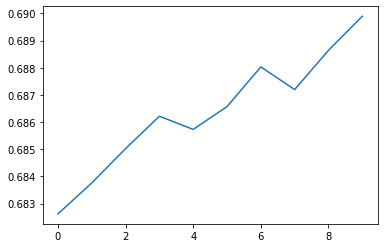

In [534]:
fig, ax1 = plt.subplots(1,1)
x = range(0, len(train_auc))
ax1.plot(x, train_auc)

In [ ]:
### Cabe mencionar que la gráfica es la del comienzo del entrenamiento, en la que se probó el modelo con únicamente 100 epochs

In [51]:
unique = np.unique(ds.User_ID)
index = np.arange(0, len(unique))
user_id_to_index = {key: value for key, value in zip(unique, index)}

In [52]:
unique = np.unique(ds.Product_ID)
index = np.arange(0, len(unique))
product_id_to_index = {key: value for key, value in zip(unique, index)}

In [53]:
user_idx = np.array([user_id_to_index[user] for user in ds.User_ID])

In [55]:
product_idx = np.array([product_id_to_index[product] for product in ds.Product_ID])

In [56]:
print(min(user_idx))
print(max(user_idx))

0
5890


In [57]:
print(min(product_idx))
print(max(product_idx))

0
3630


### Clase Dataset con embeddings

In [102]:
class CustomDatasetWithEmb(Dataset): 
    
    def __init__(self, X, user_idx, product_idx, y):
        super().__init__()
        self.X = X
        self.user_idx = user_idx
        self.product_idx = product_idx
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.user_idx[idx], self.product_idx[idx], self.y[idx]

In [103]:
user_index_train = user_idx[train_idx]  
user_index_valid = user_idx[valid_idx]
product_index_train = product_idx[train_idx]  
product_index_valid = product_idx[valid_idx]

In [104]:
train = CustomDatasetWithEmb(X_train, user_index_train, product_index_train, y_train)
valid = CustomDatasetWithEmb(X_valid, user_index_valid, product_index_valid, y_valid)

In [69]:
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=64, shuffle=True)

In [61]:
class NNetWithEmbeddings(torch.nn.Module):

    def __init__(self, number_of_users, number_of_products, d_users, d_products):

        super().__init__()
        self.users_embedding = torch.nn.Embedding(num_embeddings=number_of_users, embedding_dim=d_users)
        self.products_embedding = torch.nn.Embedding(num_embeddings=number_of_products, embedding_dim=d_products)
        self.linear_1 = torch.nn.Linear(in_features=(38 + d_users + d_products), out_features=100, bias=True) 
        self.relu_1 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=100, out_features=1, bias=True)

    def forward(self, x, user_idx, product_idx):
        user_emb = self.users_embedding(user_idx) # (64, d)
        prod_emb = self.products_embedding(product_idx) # (64, d)
        
        final_input = torch.cat([x, user_emb, prod_emb], dim=1) # (64, 38+d)

        x = self.linear_1(final_input) 
        x = self.relu_1(x)
        x = self.output(x) 
        return x

In [65]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cpu


In [66]:
nnet2 = NNetWithEmbeddings(number_of_users=len(user_idx), number_of_products=len(product_idx), d_users=8, d_products=8)

In [67]:
optimizer = torch.optim.Adam(nnet2.parameters(), lr=0.001)
loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")

### Entreno el modelo con los embeddings..

In [73]:
nnet2.to(device)

loss_list = []
train_auc = []
for epoch in range(5):

    running_loss = 0
    running_y_score = []
    running_y_label = []

    #### TRAINING ####

    for i, data in enumerate(train_dataloader):

        # datos del batch
        X_batch, user_idx_batch, product_idx_batch, y_batch = data
        X_batch = X_batch.to(device).float()
        user_idx_batch = user_idx_batch.to(device)
        product_idx_batch = product_idx_batch.to(device)
        y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()  # que el optim ponga los gradientes en 0
        y_batch_score = nnet2(X_batch, user_idx_batch, product_idx_batch).reshape(-1)
        y_batch_hat = torch.sigmoid(y_batch_score).reshape(-1)

        # backpropagation
        loss = loss_function(y_batch_score, y_batch) # calcula el loss
        loss.backward() # hacer los gradientes del loss

        # actualización de parametros
        optimizer.step() 

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())  
        running_y_label += list(y_batch.detach().cpu().numpy()) 

    # metrics
    loss_list.append(running_loss)
    fpt, tpr, _ = metrics.roc_curve(running_y_label, running_y_score)
    auc = metrics.auc(fpt, tpr)
    train_auc.append(auc)
    print(f"Epoch {epoch} | Training loss: {running_loss} | AUC: {auc}")

    #### VALIDATION ####

Epoch 0 | Training loss: 0.001366972811972289 | AUC: 1.0
Epoch 1 | Training loss: 0.00026094911812180044 | AUC: 1.0
Epoch 2 | Training loss: 6.842612808100057e-05 | AUC: 1.0
Epoch 3 | Training loss: 2.1338461557718347e-05 | AUC: 1.0
Epoch 4 | Training loss: 7.390975511611941e-06 | AUC: 1.0


In [ ]:
# Se entrenó 2 veces la red, la primera vez con 10 epochs y la segunda vez, únicamente con 5 epochs.

In [109]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#### Predicciones obtenidos con el set de validación para la red CON EMBEDDINGS:

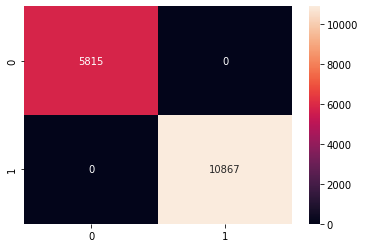

In [140]:
X_valid_torch = torch.from_numpy(X_valid)
with torch.no_grad():

    user_index_valid_t = torch.from_numpy(user_index_valid).to(device)
    product_index_valid_t = torch.from_numpy(product_index_valid).to(device)
    y_pred = nnet2(X_valid_torch.to(device).float(), user_index_valid_t, product_index_valid_t).reshape(-1)
    y_hat = torch.sigmoid(y_pred).reshape(-1).cpu().numpy()
    for item in range(len(y_hat)):
        if y_hat[item] > 0.65:
            y_hat[item] = 1
        else:
            y_hat[item] = 0

cm = confusion_matrix(y_valid, y_hat)
f = sns.heatmap(cm, annot=True, fmt='d')

#### Predicciones obtenidos con el set de validación para la red SIN EMBEDDINGS:

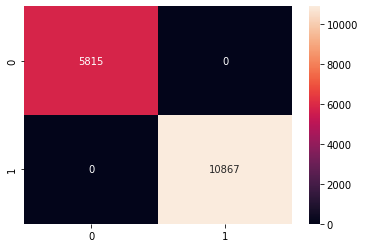

In [143]:
with torch.no_grad():
    y_pred = nnet_emb(X_valid_torch.to(device).float()).reshape(-1)
    y_hat = torch.sigmoid(y_pred).reshape(-1).cpu().numpy()
    for item in range(len(y_hat)):
        if y_hat[item] > 0.65:
            y_hat[item] = 1
        else:
            y_hat[item] = 0

cm = confusion_matrix(y_valid, y_hat)
f = sns.heatmap(cm, annot=True, fmt='d')

#### Conclusiones: 
En primer termino, la red neuronal sin embeddings se tuvo que entrenar 3 veces con 150 epochs para poder tener un alto AUC. La gráfica del comienzo del entrenamiento, del AUC vs epochs muestra que realmente fue bajo en el comienzo y el aumento del AUC fue prácticamente lineal. Se utilizó para el entrenamiento una red de 3 capas (de 200, 150 y 150 perceptrones respectivamente, y como funciones de activación, ReLUs).

La segunda red neuronal, con embeddings, se entrenó con una única capa (realmente se ralentizó muchísimo el procesamiento de cada epoch con el uso de embeddings, por ello se bajó la cantidad de layers), de 100 perceptrones, y se convergió en muy pocas epochs a un alto AUC (se ejecutó 2 veces la misma línea, la primera vez con 25 epochs, la segunda con 5).

Los resultados brindados por ambas redes así entrenadas, fueron muy perfectos en ambos casos.

#### 4 - a) Utilizando derivadas analíticas (symbolic differentiation).    

In [88]:
import sympy as sym
from sympy import *
from sympy import log
import math
from scipy.misc import derivative

In [177]:
a,b,c = sym.symbols('a,b,c')
def f(a,b,c):
    return a * log(b) + b * c ** 2
    
func = f(a,b,c)
print('f(a,b,c) = ',func)

deriv_a = func.diff(a) 
deriv_b = func.diff(b)
deriv_c = func.diff(c)

print('La derivada analítica de la función propuesta, respecto de a, es:', deriv_a)
print('La derivada analítica de la función propuesta, respecto de b, es:', deriv_b)
print('La derivada analítica de la función propuesta, respecto de c, es:', deriv_c)

f(a,b,c) =  a*log(b) + b*c**2
La derivada analítica de la función propuesta, respecto de a, es: log(b)
La derivada analítica de la función propuesta, respecto de b, es: a/b + c**2
La derivada analítica de la función propuesta, respecto de c, es: 2*b*c


In [98]:
a_=2
b_=10
c_=0.5

In [99]:
partial_deriv_a = log(b_,10)
print('La derivada de la función respecto de a, en a=2 es:', partial_deriv_a)

La derivada de la función respecto de a, en a=2 es: 1


In [100]:
partial_deriv_b = (a_/b_)+c_**2
print('La derivada de la función respecto de b, en b=10 es:', partial_deriv_b)

La derivada de la función respecto de b, en b=10 es: 0.45


In [101]:
partial_deriv_c = 2*b_*c_
print('La derivada de la función respecto de c, en c=0.5 es:', partial_deriv_c)

La derivada de la función respecto de c, en c=0.5 es: 10.0


#### 4 - b) Utilizando límite con un delta numérico pequeño (numerical differentiation).

In [215]:
def f(x, y, z):
     return x*np.log10(y) + y*z**2
 
a__ = np.arange(2,2.02,0.001)
b__ = np.arange(10,10.02,0.001)
c__ = np.arange(0.5,0.52,0.001)


In [225]:
numeric_df_da = (f(a__[1], b__[0], c__[0]) - f(a__[0], b__[0], c__[0]))/(a__[1]-a__[0])
numeric_df_da

0.9999999999995559

In [226]:
numeric_df_db = (f(a__[0], b__[1], c__[0]) - f(a__[0], b__[0], c__[0]))/(b__[1]-b__[0])
numeric_df_db

0.3368545537247504

In [227]:
numeric_df_dc = (f(a__[0], b__[0], c__[1]) - f(a__[0], b__[0], c__[0]))/(c__[1]-c__[0])
numeric_df_dc

10.0099999999994

#### 4 - c) Utilizando grafos y la regla de la cadena (chain rule differentiation)

In [157]:
from graphviz import Digraph

In [158]:
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz/bin'

In [159]:
class Graph():

    def __init__(self):
        self.operators = set()
        self.constants = set()
        self.variables = set()
        self.placeholders = set()
        global _g
        _g = self
        
    def reset_counts(self, root):
        if hasattr(root, 'count'):
            root.count = 0
        else:
            for child in root.__subclasses__():
                self.reset_counts(child)

    def reset_session(self):
        try:
            del _g
        except:
            pass
        self.reset_counts(Node)
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.reset_session()

In [160]:
class Node:
    def __init__(self):
        pass
      
 ### Placeholders ###
class Placeholder(Node):

    count = 0
    def __init__(self, name, dtype=float):
        _g.placeholders.add(self)
        self.value = None
        self.gradient = None
        self.name = f"Plc/{Placeholder.count}" if name is None else name
        Placeholder.count += 1
        
    def __repr__(self):
        return f"Placeholder: name:{self.name}, value:{self.value}"
        
### Constants ###      
class Constant(Node):
    count = 0
    def __init__(self, value, name=None):
        _g.constants.add(self)
        self._value = value
        self.gradient = None
        self.name = f"Const/{Constant.count}" if name is None else name
        Constant.count += 1
        
    def __repr__(self):
        return f"Constant: name:{self.name}, value:{self.value}"
    
    @property
    def value(self):
        return self._value
    
    @value.setter
    def value(self):
        raise ValueError("Cannot reassign constant")
        self.value = None
        self.gradient = None
        self.name = f"Plc/{Placeholder.count}" if name is None else name
        Placeholder.count += 1
        
    def __repr__(self):
        return f"Placeholder: name:{self.name}, value:{self.value}"
      
### Variables ###
class Variable(Node):
    count = 0
    def __init__(self, value, name=None):
        _g.variables.add(self)
        self.value = value
        self.gradient = None
        self.name = f"Var/{Variable.count}" if name is None else name
        Variable.count += 1
        
    def __repr__(self):
        return f"Variable: name:{self.name}, value:{self.value}"
      
### Operators ###
class Operator(Node):
    def __init__(self, name='Operator'):
        _g.operators.add(self)
        self.value = None
        self.inputs = []
        self.gradient = None
        self.name = name
    
    def __repr__(self):
        return f"Operator: name:{self.name}"

In [240]:
class add(Operator):
    count = 0
    """Binary addition operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'add/{add.count}' if name is None else name
        add.count += 1
        
    def forward(self, a, b):
        return a+b
    
    def backward(self, a, b, dout):
        return dout, dout

class multiply(Operator):
    count = 0
    """Binary multiplication operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'mul/{multiply.count}' if name is None else name
        multiply.count += 1
        
    def forward(self, a, b):
        return a*b
    
    def backward(self, a, b, dout):
        return dout*b, dout*a
    
class divide(Operator):
    count = 0
    """Binary division operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'div/{divide.count}' if name is None else name
        divide.count += 1
   
    def forward(self, a, b):
        return a/b
    
    def backward(self, a, b, dout):
        return dout/b, dout*a/np.power(b, 2)
    
    
class power(Operator):
    count = 0
    """Binary exponentiation operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'pow/{power.count}' if name is None else name
        power.count += 1
   
    def forward(self, a, b):
        return np.power(a, b)
    
    def backward(self, a, b, dout):
        return dout*b*np.power(a, (b-1)), dout*np.log(a)*np.power(a, b)
    
class log(Operator):
    count = 0
    "Logarithmic operation operation."
    def __init__(self, a, name=None):
        super().__init__(name)
        self.inputs=[a]
        self.name = f'log/{log.count}' if name is None else name
        log.count += 1
        
    def forward(self, a):
        return np.log10(a)
    
    def backward(self, a, dout):
        return dout/a
    
    
class matmul(Operator):
    count = 0
    """Binary multiplication operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'matmul/{matmul.count}' if name is None else name
        matmul.count += 1
        
    def forward(self, a, b):
        return a@b
    
    def backward(self, a, b, dout):
        return dout@b.T, a.T@dout
    

#####       Operator overloading       #####
def node_wrapper(func, self, other):
    if isinstance(other, Node):
        return func(self, other)
    if isinstance(other, float) or isinstance(other, int):
        return func(self, Constant(other))
    raise TypeError("Incompatible types.")

Node.__add__ = lambda self, other: node_wrapper(add, self, other)
Node.__mul__ = lambda self, other: node_wrapper(multiply, self, other)
Node.__div__ = lambda self, other: node_wrapper(divide, self, other)
Node.__neg__ = lambda self: node_wrapper(multiply, self, Constant(-1))
Node.__pow__ = lambda self, other: node_wrapper(power, self, other)
Node.__matmul__ = lambda self, other: node_wrapper(matmul, self, other)

In [241]:
with Graph() as g:
    x = Variable(1.3)
    y = Variable(0.9)
    z = x*y+log(x)
g.variables # Will output {Variable: name:Var/0, value:1.3, Variable: name:Var/1, value:0.9}
g.operators # Will output {Operator: name:add/0, Operator: name:mul/0}
g.constants # Will output {Constant: name:Const/0, value:5}

set()

In [259]:
#####  Topological sort  #####
def topological_sort(head_node=None, graph=_g):
    vis = set()
    ordering = []
    
    def _dfs(node):
        if node not in vis:
            vis.add(node)
            if isinstance(node, Operator):
                for input_node in node.inputs:
                    _dfs(input_node)
            ordering.append(node)
            
    if head_node is None:
        for node in graph.operators:
            _dfs(node)
    else:
        _dfs(head_node)
        
    return ordering
    

#####    Forward pass    #####
def forward_pass(order, feed_dict={}):

    for node in order:
        
        if isinstance(node, Placeholder):
            node.value = feed_dict[node.name]
                    
        elif isinstance(node, Operator):
            node.value = node.forward(*[prev_node.value for prev_node in node.inputs])

    return order[-1].value
    

#####    Backward pass   #####
def backward_pass(order, target_node=None):

    vis = set()
    order[-1].gradient = 1
    for node in reversed(order):
        if isinstance(node, Operator):
            inputs = node.inputs
            grads = node.backward(*[x.value for x in inputs], dout=node.gradient)
            if isinstance(grads, tuple):
                for inp, grad in zip(inputs, grads):
                    if inp not in vis:
                        inp.gradient = grad
                    else:
                        inp.gradient += grad
                    vis.add(inp)
            inp.gradient = grad
            vis.add(inp)
    return [node.gradient for node in order]

In [260]:
val1, val2, val3 = 2.0, 10, 0.5
with Graph() as g:
    A = Variable(val1, name='A')
    B = Variable(val2, name='B')
    C = Variable(val3, name='C')
    k = A*log(B) + B*(C**2)

    order = topological_sort(k)
    res = forward_pass(order)
    grads = backward_pass(order)

    print("Node ordering:")
    for node in order:
        print(node)

Node ordering:
Variable: name:A, value:2.0
Variable: name:B, value:10
Operator: name:log/0
Operator: name:mul/0
Variable: name:C, value:0.5
Placeholder: name:Const/0, value:2
Operator: name:pow/0
Operator: name:mul/1
Operator: name:add/0


In [262]:
dZdA_node = [a for a in order if a.name=='A'][0]
dZdB_node = [a for a in order if a.name=='B'][0]
dZdC_node = [a for a in order if a.name=='C'][0]
print(f"dZ/dA por regla de la cadena computada es = {dZdA_node.gradient}")
print(f"dZ/dB por regla de la cadena computada es = {dZdB_node.gradient}")
print(f"dZ/dC por regla de la cadena computada es = {dZdC_node.gradient}")

dZ/dA por regla de la cadena computada es = 1.0
dZ/dB por regla de la cadena computada es = 0.25
dZ/dC por regla de la cadena computada es = 10.0


In [263]:
def make_graph(graph):
    f = Digraph()
    f.attr(rankdir='LR', size='10, 8')
    f.attr('node', shape='circle')
    for node in graph:
        shape = 'box' if isinstance(node, Placeholder) else 'circle'
        f.node(node.name, label=node.name.split('/')[0], shape=shape)
    for node in graph:
        if isinstance(node, Operator):
            for e in node.inputs:
                f.edge(e.name, node.name, label=e.name)
    return f

In [264]:
order

[Variable: name:A, value:2.0,
 Variable: name:B, value:10,
 Operator: name:log/0,
 Operator: name:mul/0,
 Variable: name:C, value:0.5,
 Placeholder: name:Const/0, value:2,
 Operator: name:pow/0,
 Operator: name:mul/1,
 Operator: name:add/0]

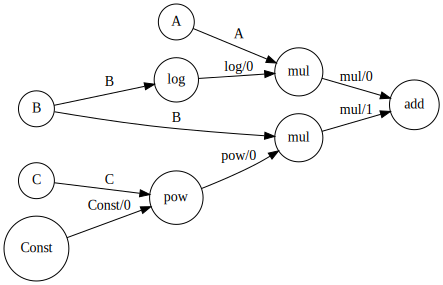

In [265]:
my_graph = make_graph(order)
my_graph

#### 4 - d) Utilizando PyTorch (automatic differentiation)

In [266]:
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(10.0, requires_grad=True)
c = torch.tensor(0.5, requires_grad=True)

In [267]:
f = (a * torch.log(b)) + (b * torch.pow(c, 2))

In [268]:
f.backward()

In [269]:
print("Derivada de f respecto de a en 2:", a.grad)
print("Derivada de f respecto de b en 10:", b.grad)
print("Derivada de f respecto de c en 0.5:", c.grad)

Derivada de f respecto de a en 2: tensor(2.3026)
Derivada de f respecto de b en 10: tensor(0.4500)
Derivada de f respecto de c en 0.5: tensor(10.)
